<a href="https://colab.research.google.com/github/pulkitsharma58/Melanoma-Detection/blob/main/project_on_MelanomaDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This project is based on Melanoma Detection dataset which contain the images of skin lesions.
# As we know that this dataset contains very less images of skin lesions so if use any other pretrained network to train this dataset, then this data will overfit and to avoid the overfitting we will use semi-supervised learning, in this project we will train the dataset on network known as GAN(generative adversial network) which will contain a Generator and a Discriminator.

In [ ]:
import tensorflow
from tensorflow import keras
from keras import preprocessing
ImageDataGenerator = preprocessing.image.ImageDataGenerator

In [ ]:
#First we will create an ImageDataGenerator to read our images from the dataset.
data_gen = ImageDataGenerator(rotation_range=90,brightness_range=(0.5,1),horizontal_flip=True,vertical_flip=True)

In [ ]:
import os
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
unlabeled_datagen = data_gen.flow_from_directory(directory="/content/drive/MyDrive/Colab Notebooks/MelanomaDetection",
                                                           target_size=(32,32),classes=['unlabeled'],batch_size=256)

Found 7018 images belonging to 1 classes.


In [ ]:
from keras.models import Sequential
from keras.layers import Input,Conv2D,LeakyReLU,Flatten,Dropout,Dense,Reshape,Conv2DTranspose,BatchNormalization
import tensorflow as tf

In [ ]:
#The discriminator is going to be a CNN which will output a scalar value(P(class=real|Xi)).
def discriminator():

  dis = Sequential(name="Discriminator")

  dis.add(Conv2D(filters=64,kernel_size=4,strides=2,padding="same",input_shape=(32,32,3),use_bias=False))
  dis.add(LeakyReLU(alpha=0.017))

  dis.add(Conv2D(filters=128,kernel_size=4,strides=2,padding="same",use_bias=False))
  dis.add(BatchNormalization())
  dis.add(LeakyReLU(alpha=0.017))

  dis.add(Conv2D(filters=256,kernel_size=4,strides=2,padding="same",use_bias=False))
  dis.add(BatchNormalization())
  dis.add(LeakyReLU(alpha=0.017))

  dis.add(Flatten())
  dis.add(Dropout(0.4))

  dis.add(Dense(units=1,activation="sigmoid"))

  return dis

In [ ]:
#The generator is going to be a CNN which will output a fake(noisy) image.
def generator():

  noise_shape = 100
  gen = Sequential(name="Generator")

  gen.add(Input(shape=(noise_shape,)))
  gen.add(Dense(units=4*4*100))
  gen.add(Reshape((4,4,100)))

  gen.add(Conv2DTranspose(filters=256,kernel_size=4,strides=1,padding="same",use_bias=False))
  gen.add(BatchNormalization())
  gen.add(LeakyReLU(alpha=0.017))

  gen.add(Conv2DTranspose(filters=128,kernel_size=4,strides=2,padding="same",use_bias=False))
  gen.add(BatchNormalization())
  gen.add(LeakyReLU(alpha=0.017))

  gen.add(Conv2DTranspose(filters=64,kernel_size=4,strides=2,padding="same",use_bias=False))
  gen.add(BatchNormalization())
  gen.add(LeakyReLU(alpha=0.017))

  gen.add(Conv2DTranspose(filters=3,kernel_size=4,strides=2,padding="same",activation="tanh",use_bias=False))

  return gen

In [ ]:
D = discriminator()

In [ ]:
G = generator()

In [ ]:
GAN_epochs = 50
noise_shape = 100
batch_size = 256

In [ ]:
import keras
from IPython import display
import numpy as np

In [ ]:
bce_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def D_loss(real_imgs_preds,fake_imgs_preds):
#In this function we will calculate the total loss of discriminator.
  real_imgs_labels = 0.05 * tf.random.uniform(shape=tf.shape(real_imgs_preds)) + tf.ones_like(real_imgs_preds)
  fake_imgs_labels = 0.05 * tf.random.uniform(shape=tf.shape(fake_imgs_preds)) + tf.zeros_like(fake_imgs_preds)

  real_imgs_bce_loss = bce_loss(y_true=real_imgs_labels,y_pred=real_imgs_preds)
  fake_imgs_bce_loss = bce_loss(y_true=fake_imgs_labels,y_pred=fake_imgs_preds)

  total_loss = real_imgs_bce_loss + fake_imgs_bce_loss

  return total_loss

In [ ]:
def G_loss(fake_imgs_preds):
#In this function we will calculate the loss of generator.
  fake_imgs_labels = tf.ones_like(fake_imgs_preds)

  return bce_loss(y_true=fake_imgs_labels,y_pred=fake_imgs_preds)

In [ ]:
D_optimizer = keras.optimizers.adam_v2.Adam(learning_rate=0.0008,beta_1=0.3)
G_optimizer = keras.optimizers.adam_v2.Adam(learning_rate=0.0004,beta_1=0.1)

In [ ]:
GAN_checkpoint_dir = "/content/drive/MyDrive/Colab Notebooks/GAN_training_checkpoints"
GAN_checkpoint_prefix = os.path.join(GAN_checkpoint_dir,"ckpt")
GAN_checkpoint = tf.train.Checkpoint(optimizer=[D_optimizer,G_optimizer],model=[D,G])

In [ ]:
@tf.function
def training_step(real_imgs_mini_batch):
#In this function we will perform the training step for GAN.

  G.trainable = False
  #first we will freeze the generator and the pass the tensor noise to generate the mini batch of fake images
  noise = tf.random.normal(shape=(batch_size,noise_shape))
  generated_imgs_mini_batch = G(noise,training=False)

  D.trainable = True
  #now we will pass the mini batch of real(256 images) and generated(256 images) images through our discriminator

  with tf.GradientTape() as disc_tape, tf.GradientTape() as gen_tape:

    real_imgs_preds = D(real_imgs_mini_batch,training=True)
    fake_imgs_preds = D(generated_imgs_mini_batch,training=True)

    #now we will compute binary cross entropy loss for discriminator 
    disc_loss = D_loss(real_imgs_preds,fake_imgs_preds)

    #now we will apply backpropagation to minimize the loss of discriminator 
    gradients_of_disc = disc_tape.gradient(disc_loss,D.trainable_variables)
    D_optimizer.apply_gradients(zip(gradients_of_disc,D.trainable_variables))
    

    D.trainable = False
    #now we will freeze the discriminator and unfreeze the generator 
    G.trainable = True

    noise = tf.random.normal(shape=(batch_size,noise_shape))
    generated_imgs_mini_batch = G(noise,training=True)

    #passing the mini batch of generated(256 images) images through discriminator 
    fake_imgs_preds = D(generated_imgs_mini_batch,training=False)

    #computing the binary cross entropy loss for generator
    gen_loss = G_loss(fake_imgs_preds)

    #applying backpropagation to minimize loss of generator
    gradients_of_gen = gen_tape.gradient(gen_loss,G.trainable_variables)
    G_optimizer.apply_gradients(zip(gradients_of_gen,G.trainable_variables))

In [ ]:
constant_noise = tf.random.normal(shape=(16,noise_shape))

In [ ]:
def generate_and_save_images(generator_model,epoch,test_input):
#This function will generate the fake images using Generator.

  generated_sample_images = generator_model(test_input,training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(generated_sample_images.shape[0]):
    plt.subplot(4,4,i+1)
    plt.imshow(generated_sample_images[i,:,:,:])
    plt.axis("off")

  plt.savefig("Images_at_Epoch_{:04d}.png".format(epoch))
  plt.show()

In [ ]:
real_imgs_path = "/content/drive/MyDrive/Colab Notebooks/MelanomaDetection/unlabeled"

In [ ]:
def train_gan(real_imgs_datagen,total_epochs):
#This function will triain GAN on total_epochs.
  for epoch in range(total_epochs):

    time_step = 1

    for image_batch in real_imgs_datagen:

      print("Training GAN at Time Step {} of Epoch {}".format(time_step,epoch+1))
      training_step(real_imgs_mini_batch=image_batch[0])
      

      if time_step > len(os.listdir(real_imgs_path))//batch_size:
        break

      time_step = time_step + 1

    generate_and_save_images(generator_model=G,epoch=epoch+1,test_input=constant_noise)

    if (epoch + 1) % 5 == 0:
      GAN_checkpoint.save(file_prefix=GAN_checkpoint_prefix)

  generate_and_save_images(generator_model=G,epoch=total_epochs,test_input=constant_noise)

Training GAN at Time Step 1 of Epoch 1


/usr/local/lib/python3.8/dist-packages/keras/backend.py:5676: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Training GAN at Time Step 2 of Epoch 1
Training GAN at Time Step 3 of Epoch 1
Training GAN at Time Step 4 of Epoch 1
Training GAN at Time Step 5 of Epoch 1
Training GAN at Time Step 6 of Epoch 1
Training GAN at Time Step 7 of Epoch 1
Training GAN at Time Step 8 of Epoch 1
Training GAN at Time Step 9 of Epoch 1
Training GAN at Time Step 10 of Epoch 1
Training GAN at Time Step 11 of Epoch 1
Training GAN at Time Step 12 of Epoch 1
Training GAN at Time Step 13 of Epoch 1
Training GAN at Time Step 14 of Epoch 1
Training GAN at Time Step 15 of Epoch 1
Training GAN at Time Step 16 of Epoch 1
Training GAN at Time Step 17 of Epoch 1
Training GAN at Time Step 18 of Epoch 1
Training GAN at Time Step 19 of Epoch 1
Training GAN at Time Step 20 of Epoch 1
Training GAN at Time Step 21 of Epoch 1
Training GAN at Time Step 22 of Epoch 1
Training GAN at Time Step 23 of Epoch 1
Training GAN at Time Step 24 of Epoch 1
Training GAN at Time Step 25 of Epoch 1
Training GAN at Time Step 26 of Epoch 1
Training

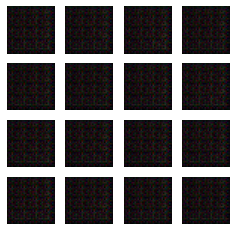

Training GAN at Time Step 1 of Epoch 2
Training GAN at Time Step 2 of Epoch 2
Training GAN at Time Step 3 of Epoch 2
Training GAN at Time Step 4 of Epoch 2
Training GAN at Time Step 5 of Epoch 2
Training GAN at Time Step 6 of Epoch 2
Training GAN at Time Step 7 of Epoch 2
Training GAN at Time Step 8 of Epoch 2
Training GAN at Time Step 9 of Epoch 2
Training GAN at Time Step 10 of Epoch 2
Training GAN at Time Step 11 of Epoch 2
Training GAN at Time Step 12 of Epoch 2
Training GAN at Time Step 13 of Epoch 2
Training GAN at Time Step 14 of Epoch 2
Training GAN at Time Step 15 of Epoch 2
Training GAN at Time Step 16 of Epoch 2
Training GAN at Time Step 17 of Epoch 2
Training GAN at Time Step 18 of Epoch 2
Training GAN at Time Step 19 of Epoch 2
Training GAN at Time Step 20 of Epoch 2
Training GAN at Time Step 21 of Epoch 2
Training GAN at Time Step 22 of Epoch 2
Training GAN at Time Step 23 of Epoch 2
Training GAN at Time Step 24 of Epoch 2
Training GAN at Time Step 25 of Epoch 2
Training 

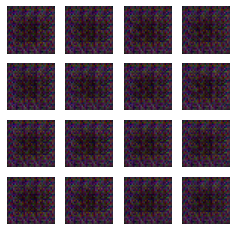

Training GAN at Time Step 1 of Epoch 3
Training GAN at Time Step 2 of Epoch 3
Training GAN at Time Step 3 of Epoch 3
Training GAN at Time Step 4 of Epoch 3
Training GAN at Time Step 5 of Epoch 3
Training GAN at Time Step 6 of Epoch 3
Training GAN at Time Step 7 of Epoch 3
Training GAN at Time Step 8 of Epoch 3
Training GAN at Time Step 9 of Epoch 3
Training GAN at Time Step 10 of Epoch 3
Training GAN at Time Step 11 of Epoch 3
Training GAN at Time Step 12 of Epoch 3
Training GAN at Time Step 13 of Epoch 3
Training GAN at Time Step 14 of Epoch 3
Training GAN at Time Step 15 of Epoch 3
Training GAN at Time Step 16 of Epoch 3
Training GAN at Time Step 17 of Epoch 3
Training GAN at Time Step 18 of Epoch 3
Training GAN at Time Step 19 of Epoch 3
Training GAN at Time Step 20 of Epoch 3
Training GAN at Time Step 21 of Epoch 3
Training GAN at Time Step 22 of Epoch 3
Training GAN at Time Step 23 of Epoch 3
Training GAN at Time Step 24 of Epoch 3
Training GAN at Time Step 25 of Epoch 3
Training 

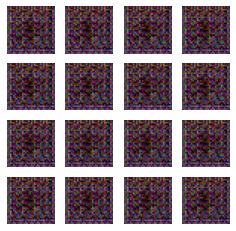

Training GAN at Time Step 1 of Epoch 4
Training GAN at Time Step 2 of Epoch 4
Training GAN at Time Step 3 of Epoch 4
Training GAN at Time Step 4 of Epoch 4
Training GAN at Time Step 5 of Epoch 4
Training GAN at Time Step 6 of Epoch 4
Training GAN at Time Step 7 of Epoch 4
Training GAN at Time Step 8 of Epoch 4
Training GAN at Time Step 9 of Epoch 4
Training GAN at Time Step 10 of Epoch 4
Training GAN at Time Step 11 of Epoch 4
Training GAN at Time Step 12 of Epoch 4
Training GAN at Time Step 13 of Epoch 4
Training GAN at Time Step 14 of Epoch 4
Training GAN at Time Step 15 of Epoch 4
Training GAN at Time Step 16 of Epoch 4
Training GAN at Time Step 17 of Epoch 4
Training GAN at Time Step 18 of Epoch 4
Training GAN at Time Step 19 of Epoch 4
Training GAN at Time Step 20 of Epoch 4
Training GAN at Time Step 21 of Epoch 4
Training GAN at Time Step 22 of Epoch 4
Training GAN at Time Step 23 of Epoch 4
Training GAN at Time Step 24 of Epoch 4
Training GAN at Time Step 25 of Epoch 4
Training 

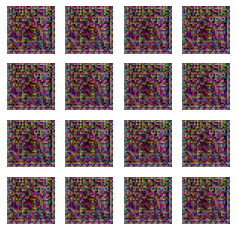

Training GAN at Time Step 1 of Epoch 5
Training GAN at Time Step 2 of Epoch 5
Training GAN at Time Step 3 of Epoch 5
Training GAN at Time Step 4 of Epoch 5
Training GAN at Time Step 5 of Epoch 5
Training GAN at Time Step 6 of Epoch 5
Training GAN at Time Step 7 of Epoch 5
Training GAN at Time Step 8 of Epoch 5
Training GAN at Time Step 9 of Epoch 5
Training GAN at Time Step 10 of Epoch 5
Training GAN at Time Step 11 of Epoch 5
Training GAN at Time Step 12 of Epoch 5
Training GAN at Time Step 13 of Epoch 5
Training GAN at Time Step 14 of Epoch 5
Training GAN at Time Step 15 of Epoch 5
Training GAN at Time Step 16 of Epoch 5
Training GAN at Time Step 17 of Epoch 5
Training GAN at Time Step 18 of Epoch 5
Training GAN at Time Step 19 of Epoch 5
Training GAN at Time Step 20 of Epoch 5
Training GAN at Time Step 21 of Epoch 5
Training GAN at Time Step 22 of Epoch 5
Training GAN at Time Step 23 of Epoch 5
Training GAN at Time Step 24 of Epoch 5
Training GAN at Time Step 25 of Epoch 5
Training 

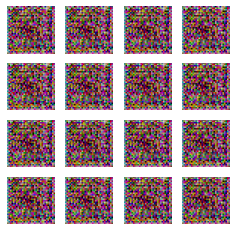

Training GAN at Time Step 1 of Epoch 6
Training GAN at Time Step 2 of Epoch 6
Training GAN at Time Step 3 of Epoch 6
Training GAN at Time Step 4 of Epoch 6
Training GAN at Time Step 5 of Epoch 6
Training GAN at Time Step 6 of Epoch 6
Training GAN at Time Step 7 of Epoch 6
Training GAN at Time Step 8 of Epoch 6
Training GAN at Time Step 9 of Epoch 6
Training GAN at Time Step 10 of Epoch 6
Training GAN at Time Step 11 of Epoch 6
Training GAN at Time Step 12 of Epoch 6
Training GAN at Time Step 13 of Epoch 6
Training GAN at Time Step 14 of Epoch 6
Training GAN at Time Step 15 of Epoch 6
Training GAN at Time Step 16 of Epoch 6
Training GAN at Time Step 17 of Epoch 6
Training GAN at Time Step 18 of Epoch 6
Training GAN at Time Step 19 of Epoch 6
Training GAN at Time Step 20 of Epoch 6
Training GAN at Time Step 21 of Epoch 6
Training GAN at Time Step 22 of Epoch 6
Training GAN at Time Step 23 of Epoch 6
Training GAN at Time Step 24 of Epoch 6
Training GAN at Time Step 25 of Epoch 6
Training 

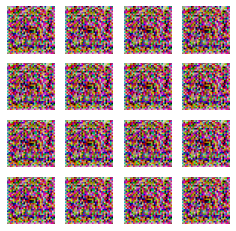

Training GAN at Time Step 1 of Epoch 7
Training GAN at Time Step 2 of Epoch 7
Training GAN at Time Step 3 of Epoch 7
Training GAN at Time Step 4 of Epoch 7
Training GAN at Time Step 5 of Epoch 7
Training GAN at Time Step 6 of Epoch 7
Training GAN at Time Step 7 of Epoch 7
Training GAN at Time Step 8 of Epoch 7
Training GAN at Time Step 9 of Epoch 7
Training GAN at Time Step 10 of Epoch 7
Training GAN at Time Step 11 of Epoch 7
Training GAN at Time Step 12 of Epoch 7
Training GAN at Time Step 13 of Epoch 7
Training GAN at Time Step 14 of Epoch 7
Training GAN at Time Step 15 of Epoch 7
Training GAN at Time Step 16 of Epoch 7
Training GAN at Time Step 17 of Epoch 7
Training GAN at Time Step 18 of Epoch 7
Training GAN at Time Step 19 of Epoch 7
Training GAN at Time Step 20 of Epoch 7
Training GAN at Time Step 21 of Epoch 7
Training GAN at Time Step 22 of Epoch 7
Training GAN at Time Step 23 of Epoch 7
Training GAN at Time Step 24 of Epoch 7
Training GAN at Time Step 25 of Epoch 7
Training 

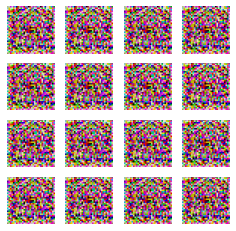

Training GAN at Time Step 1 of Epoch 8
Training GAN at Time Step 2 of Epoch 8
Training GAN at Time Step 3 of Epoch 8
Training GAN at Time Step 4 of Epoch 8
Training GAN at Time Step 5 of Epoch 8
Training GAN at Time Step 6 of Epoch 8
Training GAN at Time Step 7 of Epoch 8
Training GAN at Time Step 8 of Epoch 8
Training GAN at Time Step 9 of Epoch 8
Training GAN at Time Step 10 of Epoch 8
Training GAN at Time Step 11 of Epoch 8
Training GAN at Time Step 12 of Epoch 8
Training GAN at Time Step 13 of Epoch 8
Training GAN at Time Step 14 of Epoch 8
Training GAN at Time Step 15 of Epoch 8
Training GAN at Time Step 16 of Epoch 8
Training GAN at Time Step 17 of Epoch 8
Training GAN at Time Step 18 of Epoch 8
Training GAN at Time Step 19 of Epoch 8
Training GAN at Time Step 20 of Epoch 8
Training GAN at Time Step 21 of Epoch 8
Training GAN at Time Step 22 of Epoch 8
Training GAN at Time Step 23 of Epoch 8
Training GAN at Time Step 24 of Epoch 8
Training GAN at Time Step 25 of Epoch 8
Training 

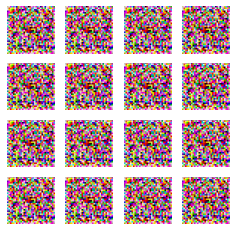

Training GAN at Time Step 1 of Epoch 9
Training GAN at Time Step 2 of Epoch 9
Training GAN at Time Step 3 of Epoch 9
Training GAN at Time Step 4 of Epoch 9
Training GAN at Time Step 5 of Epoch 9
Training GAN at Time Step 6 of Epoch 9
Training GAN at Time Step 7 of Epoch 9
Training GAN at Time Step 8 of Epoch 9
Training GAN at Time Step 9 of Epoch 9
Training GAN at Time Step 10 of Epoch 9
Training GAN at Time Step 11 of Epoch 9
Training GAN at Time Step 12 of Epoch 9
Training GAN at Time Step 13 of Epoch 9
Training GAN at Time Step 14 of Epoch 9
Training GAN at Time Step 15 of Epoch 9
Training GAN at Time Step 16 of Epoch 9
Training GAN at Time Step 17 of Epoch 9
Training GAN at Time Step 18 of Epoch 9
Training GAN at Time Step 19 of Epoch 9
Training GAN at Time Step 20 of Epoch 9
Training GAN at Time Step 21 of Epoch 9
Training GAN at Time Step 22 of Epoch 9
Training GAN at Time Step 23 of Epoch 9
Training GAN at Time Step 24 of Epoch 9
Training GAN at Time Step 25 of Epoch 9
Training 

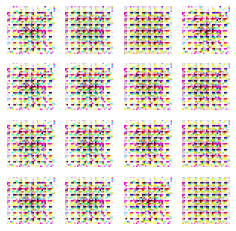

Training GAN at Time Step 1 of Epoch 10
Training GAN at Time Step 2 of Epoch 10
Training GAN at Time Step 3 of Epoch 10
Training GAN at Time Step 4 of Epoch 10
Training GAN at Time Step 5 of Epoch 10
Training GAN at Time Step 6 of Epoch 10
Training GAN at Time Step 7 of Epoch 10
Training GAN at Time Step 8 of Epoch 10
Training GAN at Time Step 9 of Epoch 10
Training GAN at Time Step 10 of Epoch 10
Training GAN at Time Step 11 of Epoch 10
Training GAN at Time Step 12 of Epoch 10
Training GAN at Time Step 13 of Epoch 10
Training GAN at Time Step 14 of Epoch 10
Training GAN at Time Step 15 of Epoch 10
Training GAN at Time Step 16 of Epoch 10
Training GAN at Time Step 17 of Epoch 10
Training GAN at Time Step 18 of Epoch 10
Training GAN at Time Step 19 of Epoch 10
Training GAN at Time Step 20 of Epoch 10
Training GAN at Time Step 21 of Epoch 10
Training GAN at Time Step 22 of Epoch 10
Training GAN at Time Step 23 of Epoch 10
Training GAN at Time Step 24 of Epoch 10
Training GAN at Time Step

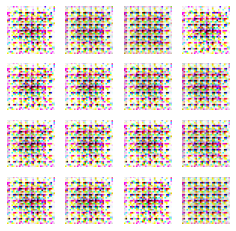

Training GAN at Time Step 1 of Epoch 11
Training GAN at Time Step 2 of Epoch 11
Training GAN at Time Step 3 of Epoch 11
Training GAN at Time Step 4 of Epoch 11
Training GAN at Time Step 5 of Epoch 11
Training GAN at Time Step 6 of Epoch 11
Training GAN at Time Step 7 of Epoch 11
Training GAN at Time Step 8 of Epoch 11
Training GAN at Time Step 9 of Epoch 11
Training GAN at Time Step 10 of Epoch 11
Training GAN at Time Step 11 of Epoch 11
Training GAN at Time Step 12 of Epoch 11
Training GAN at Time Step 13 of Epoch 11
Training GAN at Time Step 14 of Epoch 11
Training GAN at Time Step 15 of Epoch 11
Training GAN at Time Step 16 of Epoch 11
Training GAN at Time Step 17 of Epoch 11
Training GAN at Time Step 18 of Epoch 11
Training GAN at Time Step 19 of Epoch 11
Training GAN at Time Step 20 of Epoch 11
Training GAN at Time Step 21 of Epoch 11
Training GAN at Time Step 22 of Epoch 11
Training GAN at Time Step 23 of Epoch 11
Training GAN at Time Step 24 of Epoch 11
Training GAN at Time Step

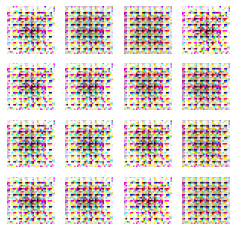

Training GAN at Time Step 1 of Epoch 12
Training GAN at Time Step 2 of Epoch 12
Training GAN at Time Step 3 of Epoch 12
Training GAN at Time Step 4 of Epoch 12
Training GAN at Time Step 5 of Epoch 12
Training GAN at Time Step 6 of Epoch 12
Training GAN at Time Step 7 of Epoch 12
Training GAN at Time Step 8 of Epoch 12
Training GAN at Time Step 9 of Epoch 12
Training GAN at Time Step 10 of Epoch 12
Training GAN at Time Step 11 of Epoch 12
Training GAN at Time Step 12 of Epoch 12
Training GAN at Time Step 13 of Epoch 12
Training GAN at Time Step 14 of Epoch 12
Training GAN at Time Step 15 of Epoch 12
Training GAN at Time Step 16 of Epoch 12
Training GAN at Time Step 17 of Epoch 12
Training GAN at Time Step 18 of Epoch 12
Training GAN at Time Step 19 of Epoch 12
Training GAN at Time Step 20 of Epoch 12
Training GAN at Time Step 21 of Epoch 12
Training GAN at Time Step 22 of Epoch 12
Training GAN at Time Step 23 of Epoch 12
Training GAN at Time Step 24 of Epoch 12
Training GAN at Time Step

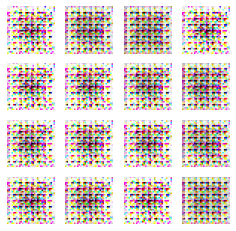

Training GAN at Time Step 1 of Epoch 13
Training GAN at Time Step 2 of Epoch 13
Training GAN at Time Step 3 of Epoch 13
Training GAN at Time Step 4 of Epoch 13
Training GAN at Time Step 5 of Epoch 13
Training GAN at Time Step 6 of Epoch 13
Training GAN at Time Step 7 of Epoch 13
Training GAN at Time Step 8 of Epoch 13
Training GAN at Time Step 9 of Epoch 13
Training GAN at Time Step 10 of Epoch 13
Training GAN at Time Step 11 of Epoch 13
Training GAN at Time Step 12 of Epoch 13
Training GAN at Time Step 13 of Epoch 13
Training GAN at Time Step 14 of Epoch 13
Training GAN at Time Step 15 of Epoch 13
Training GAN at Time Step 16 of Epoch 13
Training GAN at Time Step 17 of Epoch 13
Training GAN at Time Step 18 of Epoch 13
Training GAN at Time Step 19 of Epoch 13
Training GAN at Time Step 20 of Epoch 13
Training GAN at Time Step 21 of Epoch 13
Training GAN at Time Step 22 of Epoch 13
Training GAN at Time Step 23 of Epoch 13
Training GAN at Time Step 24 of Epoch 13
Training GAN at Time Step

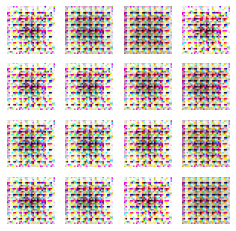

Training GAN at Time Step 1 of Epoch 14
Training GAN at Time Step 2 of Epoch 14
Training GAN at Time Step 3 of Epoch 14
Training GAN at Time Step 4 of Epoch 14
Training GAN at Time Step 5 of Epoch 14
Training GAN at Time Step 6 of Epoch 14
Training GAN at Time Step 7 of Epoch 14
Training GAN at Time Step 8 of Epoch 14
Training GAN at Time Step 9 of Epoch 14
Training GAN at Time Step 10 of Epoch 14
Training GAN at Time Step 11 of Epoch 14
Training GAN at Time Step 12 of Epoch 14
Training GAN at Time Step 13 of Epoch 14
Training GAN at Time Step 14 of Epoch 14
Training GAN at Time Step 15 of Epoch 14
Training GAN at Time Step 16 of Epoch 14
Training GAN at Time Step 17 of Epoch 14
Training GAN at Time Step 18 of Epoch 14
Training GAN at Time Step 19 of Epoch 14
Training GAN at Time Step 20 of Epoch 14
Training GAN at Time Step 21 of Epoch 14
Training GAN at Time Step 22 of Epoch 14
Training GAN at Time Step 23 of Epoch 14
Training GAN at Time Step 24 of Epoch 14
Training GAN at Time Step

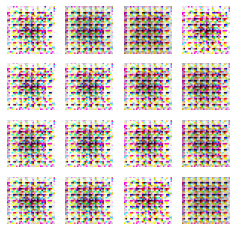

Training GAN at Time Step 1 of Epoch 15
Training GAN at Time Step 2 of Epoch 15
Training GAN at Time Step 3 of Epoch 15
Training GAN at Time Step 4 of Epoch 15
Training GAN at Time Step 5 of Epoch 15
Training GAN at Time Step 6 of Epoch 15
Training GAN at Time Step 7 of Epoch 15
Training GAN at Time Step 8 of Epoch 15
Training GAN at Time Step 9 of Epoch 15
Training GAN at Time Step 10 of Epoch 15
Training GAN at Time Step 11 of Epoch 15
Training GAN at Time Step 12 of Epoch 15
Training GAN at Time Step 13 of Epoch 15
Training GAN at Time Step 14 of Epoch 15
Training GAN at Time Step 15 of Epoch 15
Training GAN at Time Step 16 of Epoch 15
Training GAN at Time Step 17 of Epoch 15
Training GAN at Time Step 18 of Epoch 15
Training GAN at Time Step 19 of Epoch 15
Training GAN at Time Step 20 of Epoch 15
Training GAN at Time Step 21 of Epoch 15
Training GAN at Time Step 22 of Epoch 15
Training GAN at Time Step 23 of Epoch 15
Training GAN at Time Step 24 of Epoch 15
Training GAN at Time Step

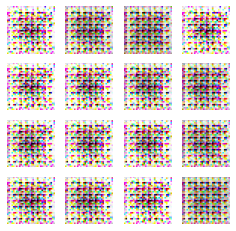

Training GAN at Time Step 1 of Epoch 16
Training GAN at Time Step 2 of Epoch 16
Training GAN at Time Step 3 of Epoch 16
Training GAN at Time Step 4 of Epoch 16
Training GAN at Time Step 5 of Epoch 16
Training GAN at Time Step 6 of Epoch 16
Training GAN at Time Step 7 of Epoch 16
Training GAN at Time Step 8 of Epoch 16
Training GAN at Time Step 9 of Epoch 16
Training GAN at Time Step 10 of Epoch 16
Training GAN at Time Step 11 of Epoch 16
Training GAN at Time Step 12 of Epoch 16
Training GAN at Time Step 13 of Epoch 16
Training GAN at Time Step 14 of Epoch 16
Training GAN at Time Step 15 of Epoch 16
Training GAN at Time Step 16 of Epoch 16
Training GAN at Time Step 17 of Epoch 16
Training GAN at Time Step 18 of Epoch 16
Training GAN at Time Step 19 of Epoch 16
Training GAN at Time Step 20 of Epoch 16
Training GAN at Time Step 21 of Epoch 16
Training GAN at Time Step 22 of Epoch 16
Training GAN at Time Step 23 of Epoch 16
Training GAN at Time Step 24 of Epoch 16
Training GAN at Time Step

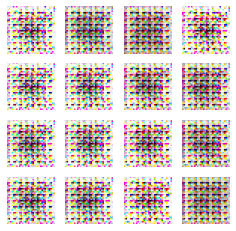

Training GAN at Time Step 1 of Epoch 17
Training GAN at Time Step 2 of Epoch 17
Training GAN at Time Step 3 of Epoch 17
Training GAN at Time Step 4 of Epoch 17
Training GAN at Time Step 5 of Epoch 17
Training GAN at Time Step 6 of Epoch 17
Training GAN at Time Step 7 of Epoch 17
Training GAN at Time Step 8 of Epoch 17
Training GAN at Time Step 9 of Epoch 17
Training GAN at Time Step 10 of Epoch 17
Training GAN at Time Step 11 of Epoch 17
Training GAN at Time Step 12 of Epoch 17
Training GAN at Time Step 13 of Epoch 17
Training GAN at Time Step 14 of Epoch 17
Training GAN at Time Step 15 of Epoch 17
Training GAN at Time Step 16 of Epoch 17
Training GAN at Time Step 17 of Epoch 17
Training GAN at Time Step 18 of Epoch 17
Training GAN at Time Step 19 of Epoch 17
Training GAN at Time Step 20 of Epoch 17
Training GAN at Time Step 21 of Epoch 17
Training GAN at Time Step 22 of Epoch 17
Training GAN at Time Step 23 of Epoch 17
Training GAN at Time Step 24 of Epoch 17
Training GAN at Time Step

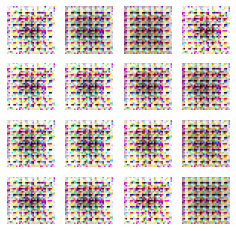

Training GAN at Time Step 1 of Epoch 18
Training GAN at Time Step 2 of Epoch 18
Training GAN at Time Step 3 of Epoch 18
Training GAN at Time Step 4 of Epoch 18
Training GAN at Time Step 5 of Epoch 18
Training GAN at Time Step 6 of Epoch 18
Training GAN at Time Step 7 of Epoch 18
Training GAN at Time Step 8 of Epoch 18
Training GAN at Time Step 9 of Epoch 18
Training GAN at Time Step 10 of Epoch 18
Training GAN at Time Step 11 of Epoch 18
Training GAN at Time Step 12 of Epoch 18
Training GAN at Time Step 13 of Epoch 18
Training GAN at Time Step 14 of Epoch 18
Training GAN at Time Step 15 of Epoch 18
Training GAN at Time Step 16 of Epoch 18
Training GAN at Time Step 17 of Epoch 18
Training GAN at Time Step 18 of Epoch 18
Training GAN at Time Step 19 of Epoch 18
Training GAN at Time Step 20 of Epoch 18
Training GAN at Time Step 21 of Epoch 18
Training GAN at Time Step 22 of Epoch 18
Training GAN at Time Step 23 of Epoch 18
Training GAN at Time Step 24 of Epoch 18
Training GAN at Time Step

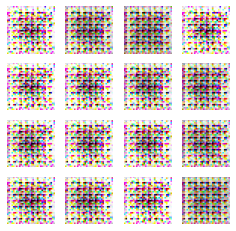

Training GAN at Time Step 1 of Epoch 19
Training GAN at Time Step 2 of Epoch 19
Training GAN at Time Step 3 of Epoch 19
Training GAN at Time Step 4 of Epoch 19
Training GAN at Time Step 5 of Epoch 19
Training GAN at Time Step 6 of Epoch 19
Training GAN at Time Step 7 of Epoch 19
Training GAN at Time Step 8 of Epoch 19
Training GAN at Time Step 9 of Epoch 19
Training GAN at Time Step 10 of Epoch 19
Training GAN at Time Step 11 of Epoch 19
Training GAN at Time Step 12 of Epoch 19
Training GAN at Time Step 13 of Epoch 19
Training GAN at Time Step 14 of Epoch 19
Training GAN at Time Step 15 of Epoch 19
Training GAN at Time Step 16 of Epoch 19
Training GAN at Time Step 17 of Epoch 19
Training GAN at Time Step 18 of Epoch 19
Training GAN at Time Step 19 of Epoch 19
Training GAN at Time Step 20 of Epoch 19
Training GAN at Time Step 21 of Epoch 19
Training GAN at Time Step 22 of Epoch 19
Training GAN at Time Step 23 of Epoch 19
Training GAN at Time Step 24 of Epoch 19
Training GAN at Time Step

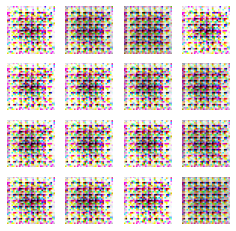

Training GAN at Time Step 1 of Epoch 20
Training GAN at Time Step 2 of Epoch 20
Training GAN at Time Step 3 of Epoch 20
Training GAN at Time Step 4 of Epoch 20
Training GAN at Time Step 5 of Epoch 20
Training GAN at Time Step 6 of Epoch 20
Training GAN at Time Step 7 of Epoch 20
Training GAN at Time Step 8 of Epoch 20
Training GAN at Time Step 9 of Epoch 20
Training GAN at Time Step 10 of Epoch 20
Training GAN at Time Step 11 of Epoch 20
Training GAN at Time Step 12 of Epoch 20
Training GAN at Time Step 13 of Epoch 20
Training GAN at Time Step 14 of Epoch 20
Training GAN at Time Step 15 of Epoch 20
Training GAN at Time Step 16 of Epoch 20
Training GAN at Time Step 17 of Epoch 20
Training GAN at Time Step 18 of Epoch 20
Training GAN at Time Step 19 of Epoch 20
Training GAN at Time Step 20 of Epoch 20
Training GAN at Time Step 21 of Epoch 20
Training GAN at Time Step 22 of Epoch 20
Training GAN at Time Step 23 of Epoch 20
Training GAN at Time Step 24 of Epoch 20
Training GAN at Time Step

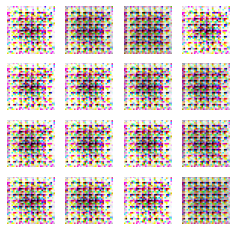

Training GAN at Time Step 1 of Epoch 21
Training GAN at Time Step 2 of Epoch 21
Training GAN at Time Step 3 of Epoch 21
Training GAN at Time Step 4 of Epoch 21
Training GAN at Time Step 5 of Epoch 21
Training GAN at Time Step 6 of Epoch 21
Training GAN at Time Step 7 of Epoch 21
Training GAN at Time Step 8 of Epoch 21
Training GAN at Time Step 9 of Epoch 21
Training GAN at Time Step 10 of Epoch 21
Training GAN at Time Step 11 of Epoch 21
Training GAN at Time Step 12 of Epoch 21
Training GAN at Time Step 13 of Epoch 21
Training GAN at Time Step 14 of Epoch 21
Training GAN at Time Step 15 of Epoch 21
Training GAN at Time Step 16 of Epoch 21
Training GAN at Time Step 17 of Epoch 21
Training GAN at Time Step 18 of Epoch 21
Training GAN at Time Step 19 of Epoch 21
Training GAN at Time Step 20 of Epoch 21
Training GAN at Time Step 21 of Epoch 21
Training GAN at Time Step 22 of Epoch 21
Training GAN at Time Step 23 of Epoch 21
Training GAN at Time Step 24 of Epoch 21
Training GAN at Time Step

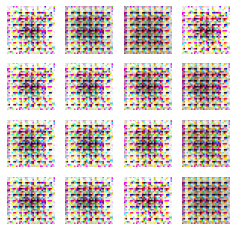

Training GAN at Time Step 1 of Epoch 22
Training GAN at Time Step 2 of Epoch 22
Training GAN at Time Step 3 of Epoch 22
Training GAN at Time Step 4 of Epoch 22
Training GAN at Time Step 5 of Epoch 22
Training GAN at Time Step 6 of Epoch 22
Training GAN at Time Step 7 of Epoch 22
Training GAN at Time Step 8 of Epoch 22
Training GAN at Time Step 9 of Epoch 22
Training GAN at Time Step 10 of Epoch 22
Training GAN at Time Step 11 of Epoch 22
Training GAN at Time Step 12 of Epoch 22
Training GAN at Time Step 13 of Epoch 22
Training GAN at Time Step 14 of Epoch 22
Training GAN at Time Step 15 of Epoch 22
Training GAN at Time Step 16 of Epoch 22
Training GAN at Time Step 17 of Epoch 22
Training GAN at Time Step 18 of Epoch 22
Training GAN at Time Step 19 of Epoch 22
Training GAN at Time Step 20 of Epoch 22
Training GAN at Time Step 21 of Epoch 22
Training GAN at Time Step 22 of Epoch 22
Training GAN at Time Step 23 of Epoch 22
Training GAN at Time Step 24 of Epoch 22
Training GAN at Time Step

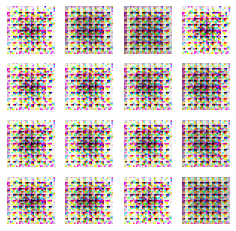

Training GAN at Time Step 1 of Epoch 23
Training GAN at Time Step 2 of Epoch 23
Training GAN at Time Step 3 of Epoch 23
Training GAN at Time Step 4 of Epoch 23
Training GAN at Time Step 5 of Epoch 23
Training GAN at Time Step 6 of Epoch 23
Training GAN at Time Step 7 of Epoch 23
Training GAN at Time Step 8 of Epoch 23
Training GAN at Time Step 9 of Epoch 23
Training GAN at Time Step 10 of Epoch 23
Training GAN at Time Step 11 of Epoch 23
Training GAN at Time Step 12 of Epoch 23
Training GAN at Time Step 13 of Epoch 23
Training GAN at Time Step 14 of Epoch 23
Training GAN at Time Step 15 of Epoch 23
Training GAN at Time Step 16 of Epoch 23
Training GAN at Time Step 17 of Epoch 23
Training GAN at Time Step 18 of Epoch 23
Training GAN at Time Step 19 of Epoch 23
Training GAN at Time Step 20 of Epoch 23
Training GAN at Time Step 21 of Epoch 23
Training GAN at Time Step 22 of Epoch 23
Training GAN at Time Step 23 of Epoch 23
Training GAN at Time Step 24 of Epoch 23
Training GAN at Time Step

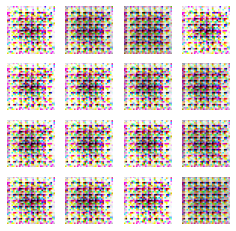

Training GAN at Time Step 1 of Epoch 24
Training GAN at Time Step 2 of Epoch 24
Training GAN at Time Step 3 of Epoch 24
Training GAN at Time Step 4 of Epoch 24
Training GAN at Time Step 5 of Epoch 24
Training GAN at Time Step 6 of Epoch 24
Training GAN at Time Step 7 of Epoch 24
Training GAN at Time Step 8 of Epoch 24
Training GAN at Time Step 9 of Epoch 24
Training GAN at Time Step 10 of Epoch 24
Training GAN at Time Step 11 of Epoch 24
Training GAN at Time Step 12 of Epoch 24
Training GAN at Time Step 13 of Epoch 24
Training GAN at Time Step 14 of Epoch 24
Training GAN at Time Step 15 of Epoch 24
Training GAN at Time Step 16 of Epoch 24
Training GAN at Time Step 17 of Epoch 24
Training GAN at Time Step 18 of Epoch 24
Training GAN at Time Step 19 of Epoch 24
Training GAN at Time Step 20 of Epoch 24
Training GAN at Time Step 21 of Epoch 24
Training GAN at Time Step 22 of Epoch 24
Training GAN at Time Step 23 of Epoch 24
Training GAN at Time Step 24 of Epoch 24
Training GAN at Time Step

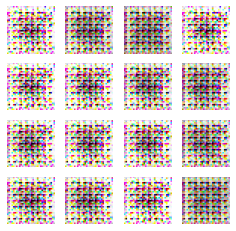

Training GAN at Time Step 1 of Epoch 25
Training GAN at Time Step 2 of Epoch 25
Training GAN at Time Step 3 of Epoch 25
Training GAN at Time Step 4 of Epoch 25
Training GAN at Time Step 5 of Epoch 25
Training GAN at Time Step 6 of Epoch 25
Training GAN at Time Step 7 of Epoch 25
Training GAN at Time Step 8 of Epoch 25
Training GAN at Time Step 9 of Epoch 25
Training GAN at Time Step 10 of Epoch 25
Training GAN at Time Step 11 of Epoch 25
Training GAN at Time Step 12 of Epoch 25
Training GAN at Time Step 13 of Epoch 25
Training GAN at Time Step 14 of Epoch 25
Training GAN at Time Step 15 of Epoch 25
Training GAN at Time Step 16 of Epoch 25
Training GAN at Time Step 17 of Epoch 25
Training GAN at Time Step 18 of Epoch 25
Training GAN at Time Step 19 of Epoch 25
Training GAN at Time Step 20 of Epoch 25
Training GAN at Time Step 21 of Epoch 25
Training GAN at Time Step 22 of Epoch 25
Training GAN at Time Step 23 of Epoch 25
Training GAN at Time Step 24 of Epoch 25
Training GAN at Time Step

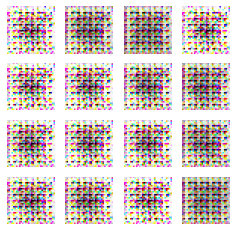

Training GAN at Time Step 1 of Epoch 26
Training GAN at Time Step 2 of Epoch 26
Training GAN at Time Step 3 of Epoch 26
Training GAN at Time Step 4 of Epoch 26
Training GAN at Time Step 5 of Epoch 26
Training GAN at Time Step 6 of Epoch 26
Training GAN at Time Step 7 of Epoch 26
Training GAN at Time Step 8 of Epoch 26
Training GAN at Time Step 9 of Epoch 26
Training GAN at Time Step 10 of Epoch 26
Training GAN at Time Step 11 of Epoch 26
Training GAN at Time Step 12 of Epoch 26
Training GAN at Time Step 13 of Epoch 26
Training GAN at Time Step 14 of Epoch 26
Training GAN at Time Step 15 of Epoch 26
Training GAN at Time Step 16 of Epoch 26
Training GAN at Time Step 17 of Epoch 26
Training GAN at Time Step 18 of Epoch 26
Training GAN at Time Step 19 of Epoch 26
Training GAN at Time Step 20 of Epoch 26
Training GAN at Time Step 21 of Epoch 26
Training GAN at Time Step 22 of Epoch 26
Training GAN at Time Step 23 of Epoch 26
Training GAN at Time Step 24 of Epoch 26
Training GAN at Time Step

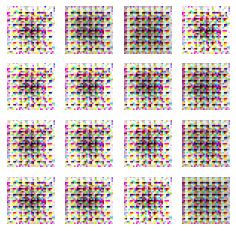

Training GAN at Time Step 1 of Epoch 27
Training GAN at Time Step 2 of Epoch 27
Training GAN at Time Step 3 of Epoch 27
Training GAN at Time Step 4 of Epoch 27
Training GAN at Time Step 5 of Epoch 27
Training GAN at Time Step 6 of Epoch 27
Training GAN at Time Step 7 of Epoch 27
Training GAN at Time Step 8 of Epoch 27
Training GAN at Time Step 9 of Epoch 27
Training GAN at Time Step 10 of Epoch 27
Training GAN at Time Step 11 of Epoch 27
Training GAN at Time Step 12 of Epoch 27
Training GAN at Time Step 13 of Epoch 27
Training GAN at Time Step 14 of Epoch 27
Training GAN at Time Step 15 of Epoch 27
Training GAN at Time Step 16 of Epoch 27
Training GAN at Time Step 17 of Epoch 27
Training GAN at Time Step 18 of Epoch 27
Training GAN at Time Step 19 of Epoch 27
Training GAN at Time Step 20 of Epoch 27
Training GAN at Time Step 21 of Epoch 27
Training GAN at Time Step 22 of Epoch 27
Training GAN at Time Step 23 of Epoch 27
Training GAN at Time Step 24 of Epoch 27
Training GAN at Time Step

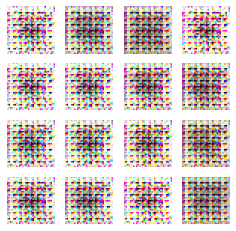

Training GAN at Time Step 1 of Epoch 28
Training GAN at Time Step 2 of Epoch 28
Training GAN at Time Step 3 of Epoch 28
Training GAN at Time Step 4 of Epoch 28
Training GAN at Time Step 5 of Epoch 28
Training GAN at Time Step 6 of Epoch 28
Training GAN at Time Step 7 of Epoch 28
Training GAN at Time Step 8 of Epoch 28
Training GAN at Time Step 9 of Epoch 28
Training GAN at Time Step 10 of Epoch 28
Training GAN at Time Step 11 of Epoch 28
Training GAN at Time Step 12 of Epoch 28
Training GAN at Time Step 13 of Epoch 28
Training GAN at Time Step 14 of Epoch 28
Training GAN at Time Step 15 of Epoch 28
Training GAN at Time Step 16 of Epoch 28
Training GAN at Time Step 17 of Epoch 28
Training GAN at Time Step 18 of Epoch 28
Training GAN at Time Step 19 of Epoch 28
Training GAN at Time Step 20 of Epoch 28
Training GAN at Time Step 21 of Epoch 28
Training GAN at Time Step 22 of Epoch 28
Training GAN at Time Step 23 of Epoch 28
Training GAN at Time Step 24 of Epoch 28
Training GAN at Time Step

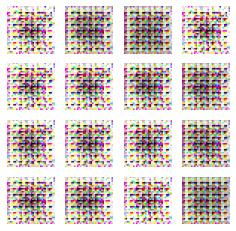

Training GAN at Time Step 1 of Epoch 29
Training GAN at Time Step 2 of Epoch 29
Training GAN at Time Step 3 of Epoch 29
Training GAN at Time Step 4 of Epoch 29
Training GAN at Time Step 5 of Epoch 29
Training GAN at Time Step 6 of Epoch 29
Training GAN at Time Step 7 of Epoch 29
Training GAN at Time Step 8 of Epoch 29
Training GAN at Time Step 9 of Epoch 29
Training GAN at Time Step 10 of Epoch 29
Training GAN at Time Step 11 of Epoch 29
Training GAN at Time Step 12 of Epoch 29
Training GAN at Time Step 13 of Epoch 29
Training GAN at Time Step 14 of Epoch 29
Training GAN at Time Step 15 of Epoch 29
Training GAN at Time Step 16 of Epoch 29
Training GAN at Time Step 17 of Epoch 29
Training GAN at Time Step 18 of Epoch 29
Training GAN at Time Step 19 of Epoch 29
Training GAN at Time Step 20 of Epoch 29
Training GAN at Time Step 21 of Epoch 29
Training GAN at Time Step 22 of Epoch 29
Training GAN at Time Step 23 of Epoch 29
Training GAN at Time Step 24 of Epoch 29
Training GAN at Time Step

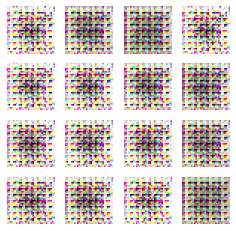

Training GAN at Time Step 1 of Epoch 30
Training GAN at Time Step 2 of Epoch 30
Training GAN at Time Step 3 of Epoch 30
Training GAN at Time Step 4 of Epoch 30
Training GAN at Time Step 5 of Epoch 30
Training GAN at Time Step 6 of Epoch 30
Training GAN at Time Step 7 of Epoch 30
Training GAN at Time Step 8 of Epoch 30
Training GAN at Time Step 9 of Epoch 30
Training GAN at Time Step 10 of Epoch 30
Training GAN at Time Step 11 of Epoch 30
Training GAN at Time Step 12 of Epoch 30
Training GAN at Time Step 13 of Epoch 30
Training GAN at Time Step 14 of Epoch 30
Training GAN at Time Step 15 of Epoch 30
Training GAN at Time Step 16 of Epoch 30
Training GAN at Time Step 17 of Epoch 30
Training GAN at Time Step 18 of Epoch 30
Training GAN at Time Step 19 of Epoch 30
Training GAN at Time Step 20 of Epoch 30
Training GAN at Time Step 21 of Epoch 30
Training GAN at Time Step 22 of Epoch 30
Training GAN at Time Step 23 of Epoch 30
Training GAN at Time Step 24 of Epoch 30
Training GAN at Time Step

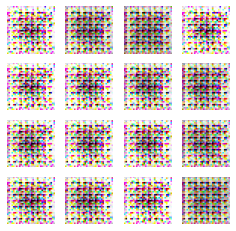

Training GAN at Time Step 1 of Epoch 31
Training GAN at Time Step 2 of Epoch 31
Training GAN at Time Step 3 of Epoch 31
Training GAN at Time Step 4 of Epoch 31
Training GAN at Time Step 5 of Epoch 31
Training GAN at Time Step 6 of Epoch 31
Training GAN at Time Step 7 of Epoch 31
Training GAN at Time Step 8 of Epoch 31
Training GAN at Time Step 9 of Epoch 31
Training GAN at Time Step 10 of Epoch 31
Training GAN at Time Step 11 of Epoch 31
Training GAN at Time Step 12 of Epoch 31
Training GAN at Time Step 13 of Epoch 31
Training GAN at Time Step 14 of Epoch 31
Training GAN at Time Step 15 of Epoch 31
Training GAN at Time Step 16 of Epoch 31
Training GAN at Time Step 17 of Epoch 31
Training GAN at Time Step 18 of Epoch 31
Training GAN at Time Step 19 of Epoch 31
Training GAN at Time Step 20 of Epoch 31
Training GAN at Time Step 21 of Epoch 31
Training GAN at Time Step 22 of Epoch 31
Training GAN at Time Step 23 of Epoch 31
Training GAN at Time Step 24 of Epoch 31
Training GAN at Time Step

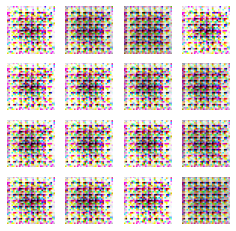

Training GAN at Time Step 1 of Epoch 32
Training GAN at Time Step 2 of Epoch 32
Training GAN at Time Step 3 of Epoch 32
Training GAN at Time Step 4 of Epoch 32
Training GAN at Time Step 5 of Epoch 32
Training GAN at Time Step 6 of Epoch 32
Training GAN at Time Step 7 of Epoch 32
Training GAN at Time Step 8 of Epoch 32
Training GAN at Time Step 9 of Epoch 32
Training GAN at Time Step 10 of Epoch 32
Training GAN at Time Step 11 of Epoch 32
Training GAN at Time Step 12 of Epoch 32
Training GAN at Time Step 13 of Epoch 32
Training GAN at Time Step 14 of Epoch 32
Training GAN at Time Step 15 of Epoch 32
Training GAN at Time Step 16 of Epoch 32
Training GAN at Time Step 17 of Epoch 32
Training GAN at Time Step 18 of Epoch 32
Training GAN at Time Step 19 of Epoch 32
Training GAN at Time Step 20 of Epoch 32
Training GAN at Time Step 21 of Epoch 32
Training GAN at Time Step 22 of Epoch 32
Training GAN at Time Step 23 of Epoch 32
Training GAN at Time Step 24 of Epoch 32
Training GAN at Time Step

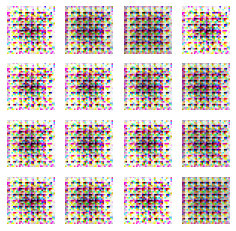

Training GAN at Time Step 1 of Epoch 33
Training GAN at Time Step 2 of Epoch 33
Training GAN at Time Step 3 of Epoch 33
Training GAN at Time Step 4 of Epoch 33
Training GAN at Time Step 5 of Epoch 33
Training GAN at Time Step 6 of Epoch 33
Training GAN at Time Step 7 of Epoch 33
Training GAN at Time Step 8 of Epoch 33
Training GAN at Time Step 9 of Epoch 33
Training GAN at Time Step 10 of Epoch 33
Training GAN at Time Step 11 of Epoch 33
Training GAN at Time Step 12 of Epoch 33
Training GAN at Time Step 13 of Epoch 33
Training GAN at Time Step 14 of Epoch 33
Training GAN at Time Step 15 of Epoch 33
Training GAN at Time Step 16 of Epoch 33
Training GAN at Time Step 17 of Epoch 33
Training GAN at Time Step 18 of Epoch 33
Training GAN at Time Step 19 of Epoch 33
Training GAN at Time Step 20 of Epoch 33
Training GAN at Time Step 21 of Epoch 33
Training GAN at Time Step 22 of Epoch 33
Training GAN at Time Step 23 of Epoch 33
Training GAN at Time Step 24 of Epoch 33
Training GAN at Time Step

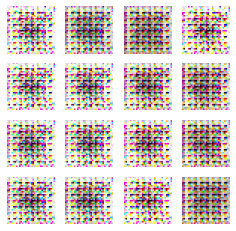

Training GAN at Time Step 1 of Epoch 34
Training GAN at Time Step 2 of Epoch 34
Training GAN at Time Step 3 of Epoch 34
Training GAN at Time Step 4 of Epoch 34
Training GAN at Time Step 5 of Epoch 34
Training GAN at Time Step 6 of Epoch 34
Training GAN at Time Step 7 of Epoch 34
Training GAN at Time Step 8 of Epoch 34
Training GAN at Time Step 9 of Epoch 34
Training GAN at Time Step 10 of Epoch 34
Training GAN at Time Step 11 of Epoch 34
Training GAN at Time Step 12 of Epoch 34
Training GAN at Time Step 13 of Epoch 34
Training GAN at Time Step 14 of Epoch 34
Training GAN at Time Step 15 of Epoch 34
Training GAN at Time Step 16 of Epoch 34
Training GAN at Time Step 17 of Epoch 34
Training GAN at Time Step 18 of Epoch 34
Training GAN at Time Step 19 of Epoch 34
Training GAN at Time Step 20 of Epoch 34
Training GAN at Time Step 21 of Epoch 34
Training GAN at Time Step 22 of Epoch 34
Training GAN at Time Step 23 of Epoch 34
Training GAN at Time Step 24 of Epoch 34
Training GAN at Time Step

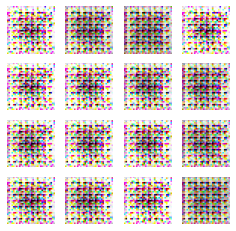

Training GAN at Time Step 1 of Epoch 35
Training GAN at Time Step 2 of Epoch 35
Training GAN at Time Step 3 of Epoch 35
Training GAN at Time Step 4 of Epoch 35
Training GAN at Time Step 5 of Epoch 35
Training GAN at Time Step 6 of Epoch 35
Training GAN at Time Step 7 of Epoch 35
Training GAN at Time Step 8 of Epoch 35
Training GAN at Time Step 9 of Epoch 35
Training GAN at Time Step 10 of Epoch 35
Training GAN at Time Step 11 of Epoch 35
Training GAN at Time Step 12 of Epoch 35
Training GAN at Time Step 13 of Epoch 35
Training GAN at Time Step 14 of Epoch 35
Training GAN at Time Step 15 of Epoch 35
Training GAN at Time Step 16 of Epoch 35
Training GAN at Time Step 17 of Epoch 35
Training GAN at Time Step 18 of Epoch 35
Training GAN at Time Step 19 of Epoch 35
Training GAN at Time Step 20 of Epoch 35
Training GAN at Time Step 21 of Epoch 35
Training GAN at Time Step 22 of Epoch 35
Training GAN at Time Step 23 of Epoch 35
Training GAN at Time Step 24 of Epoch 35
Training GAN at Time Step

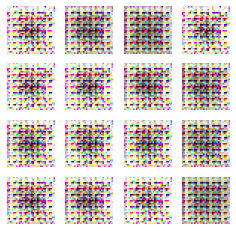

Training GAN at Time Step 1 of Epoch 36
Training GAN at Time Step 2 of Epoch 36
Training GAN at Time Step 3 of Epoch 36
Training GAN at Time Step 4 of Epoch 36
Training GAN at Time Step 5 of Epoch 36
Training GAN at Time Step 6 of Epoch 36
Training GAN at Time Step 7 of Epoch 36
Training GAN at Time Step 8 of Epoch 36
Training GAN at Time Step 9 of Epoch 36
Training GAN at Time Step 10 of Epoch 36
Training GAN at Time Step 11 of Epoch 36
Training GAN at Time Step 12 of Epoch 36
Training GAN at Time Step 13 of Epoch 36
Training GAN at Time Step 14 of Epoch 36
Training GAN at Time Step 15 of Epoch 36
Training GAN at Time Step 16 of Epoch 36
Training GAN at Time Step 17 of Epoch 36
Training GAN at Time Step 18 of Epoch 36
Training GAN at Time Step 19 of Epoch 36
Training GAN at Time Step 20 of Epoch 36
Training GAN at Time Step 21 of Epoch 36
Training GAN at Time Step 22 of Epoch 36
Training GAN at Time Step 23 of Epoch 36
Training GAN at Time Step 24 of Epoch 36
Training GAN at Time Step

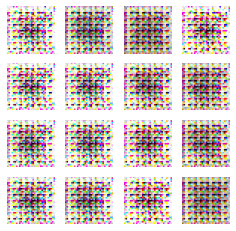

Training GAN at Time Step 1 of Epoch 37
Training GAN at Time Step 2 of Epoch 37
Training GAN at Time Step 3 of Epoch 37
Training GAN at Time Step 4 of Epoch 37
Training GAN at Time Step 5 of Epoch 37
Training GAN at Time Step 6 of Epoch 37
Training GAN at Time Step 7 of Epoch 37
Training GAN at Time Step 8 of Epoch 37
Training GAN at Time Step 9 of Epoch 37
Training GAN at Time Step 10 of Epoch 37
Training GAN at Time Step 11 of Epoch 37
Training GAN at Time Step 12 of Epoch 37
Training GAN at Time Step 13 of Epoch 37
Training GAN at Time Step 14 of Epoch 37
Training GAN at Time Step 15 of Epoch 37
Training GAN at Time Step 16 of Epoch 37
Training GAN at Time Step 17 of Epoch 37
Training GAN at Time Step 18 of Epoch 37
Training GAN at Time Step 19 of Epoch 37
Training GAN at Time Step 20 of Epoch 37
Training GAN at Time Step 21 of Epoch 37
Training GAN at Time Step 22 of Epoch 37
Training GAN at Time Step 23 of Epoch 37
Training GAN at Time Step 24 of Epoch 37
Training GAN at Time Step

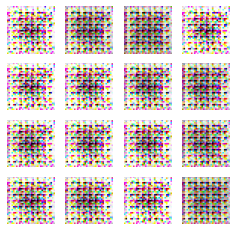

Training GAN at Time Step 1 of Epoch 38
Training GAN at Time Step 2 of Epoch 38
Training GAN at Time Step 3 of Epoch 38
Training GAN at Time Step 4 of Epoch 38
Training GAN at Time Step 5 of Epoch 38
Training GAN at Time Step 6 of Epoch 38
Training GAN at Time Step 7 of Epoch 38
Training GAN at Time Step 8 of Epoch 38
Training GAN at Time Step 9 of Epoch 38
Training GAN at Time Step 10 of Epoch 38
Training GAN at Time Step 11 of Epoch 38
Training GAN at Time Step 12 of Epoch 38
Training GAN at Time Step 13 of Epoch 38
Training GAN at Time Step 14 of Epoch 38
Training GAN at Time Step 15 of Epoch 38
Training GAN at Time Step 16 of Epoch 38
Training GAN at Time Step 17 of Epoch 38
Training GAN at Time Step 18 of Epoch 38
Training GAN at Time Step 19 of Epoch 38
Training GAN at Time Step 20 of Epoch 38
Training GAN at Time Step 21 of Epoch 38
Training GAN at Time Step 22 of Epoch 38
Training GAN at Time Step 23 of Epoch 38
Training GAN at Time Step 24 of Epoch 38
Training GAN at Time Step

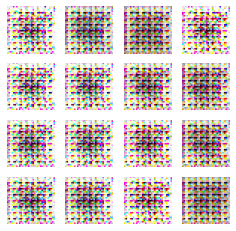

Training GAN at Time Step 1 of Epoch 39
Training GAN at Time Step 2 of Epoch 39
Training GAN at Time Step 3 of Epoch 39
Training GAN at Time Step 4 of Epoch 39
Training GAN at Time Step 5 of Epoch 39
Training GAN at Time Step 6 of Epoch 39
Training GAN at Time Step 7 of Epoch 39
Training GAN at Time Step 8 of Epoch 39
Training GAN at Time Step 9 of Epoch 39
Training GAN at Time Step 10 of Epoch 39
Training GAN at Time Step 11 of Epoch 39
Training GAN at Time Step 12 of Epoch 39
Training GAN at Time Step 13 of Epoch 39
Training GAN at Time Step 14 of Epoch 39
Training GAN at Time Step 15 of Epoch 39
Training GAN at Time Step 16 of Epoch 39
Training GAN at Time Step 17 of Epoch 39
Training GAN at Time Step 18 of Epoch 39
Training GAN at Time Step 19 of Epoch 39
Training GAN at Time Step 20 of Epoch 39
Training GAN at Time Step 21 of Epoch 39
Training GAN at Time Step 22 of Epoch 39
Training GAN at Time Step 23 of Epoch 39
Training GAN at Time Step 24 of Epoch 39
Training GAN at Time Step

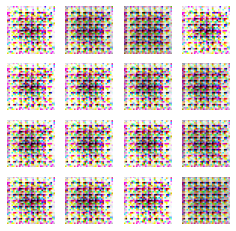

Training GAN at Time Step 1 of Epoch 40
Training GAN at Time Step 2 of Epoch 40
Training GAN at Time Step 3 of Epoch 40
Training GAN at Time Step 4 of Epoch 40
Training GAN at Time Step 5 of Epoch 40
Training GAN at Time Step 6 of Epoch 40
Training GAN at Time Step 7 of Epoch 40
Training GAN at Time Step 8 of Epoch 40
Training GAN at Time Step 9 of Epoch 40
Training GAN at Time Step 10 of Epoch 40
Training GAN at Time Step 11 of Epoch 40
Training GAN at Time Step 12 of Epoch 40
Training GAN at Time Step 13 of Epoch 40
Training GAN at Time Step 14 of Epoch 40
Training GAN at Time Step 15 of Epoch 40
Training GAN at Time Step 16 of Epoch 40
Training GAN at Time Step 17 of Epoch 40
Training GAN at Time Step 18 of Epoch 40
Training GAN at Time Step 19 of Epoch 40
Training GAN at Time Step 20 of Epoch 40
Training GAN at Time Step 21 of Epoch 40
Training GAN at Time Step 22 of Epoch 40
Training GAN at Time Step 23 of Epoch 40
Training GAN at Time Step 24 of Epoch 40
Training GAN at Time Step

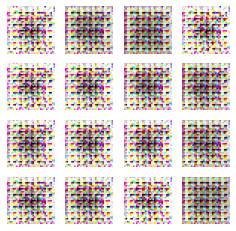

Training GAN at Time Step 1 of Epoch 41
Training GAN at Time Step 2 of Epoch 41
Training GAN at Time Step 3 of Epoch 41
Training GAN at Time Step 4 of Epoch 41
Training GAN at Time Step 5 of Epoch 41
Training GAN at Time Step 6 of Epoch 41
Training GAN at Time Step 7 of Epoch 41
Training GAN at Time Step 8 of Epoch 41
Training GAN at Time Step 9 of Epoch 41
Training GAN at Time Step 10 of Epoch 41
Training GAN at Time Step 11 of Epoch 41
Training GAN at Time Step 12 of Epoch 41
Training GAN at Time Step 13 of Epoch 41
Training GAN at Time Step 14 of Epoch 41
Training GAN at Time Step 15 of Epoch 41
Training GAN at Time Step 16 of Epoch 41
Training GAN at Time Step 17 of Epoch 41
Training GAN at Time Step 18 of Epoch 41
Training GAN at Time Step 19 of Epoch 41
Training GAN at Time Step 20 of Epoch 41
Training GAN at Time Step 21 of Epoch 41
Training GAN at Time Step 22 of Epoch 41
Training GAN at Time Step 23 of Epoch 41
Training GAN at Time Step 24 of Epoch 41
Training GAN at Time Step

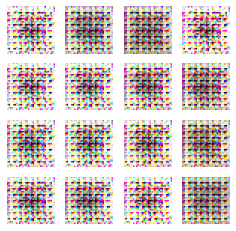

Training GAN at Time Step 1 of Epoch 42
Training GAN at Time Step 2 of Epoch 42
Training GAN at Time Step 3 of Epoch 42
Training GAN at Time Step 4 of Epoch 42
Training GAN at Time Step 5 of Epoch 42
Training GAN at Time Step 6 of Epoch 42
Training GAN at Time Step 7 of Epoch 42
Training GAN at Time Step 8 of Epoch 42
Training GAN at Time Step 9 of Epoch 42
Training GAN at Time Step 10 of Epoch 42
Training GAN at Time Step 11 of Epoch 42
Training GAN at Time Step 12 of Epoch 42
Training GAN at Time Step 13 of Epoch 42
Training GAN at Time Step 14 of Epoch 42
Training GAN at Time Step 15 of Epoch 42
Training GAN at Time Step 16 of Epoch 42
Training GAN at Time Step 17 of Epoch 42
Training GAN at Time Step 18 of Epoch 42
Training GAN at Time Step 19 of Epoch 42
Training GAN at Time Step 20 of Epoch 42
Training GAN at Time Step 21 of Epoch 42
Training GAN at Time Step 22 of Epoch 42
Training GAN at Time Step 23 of Epoch 42
Training GAN at Time Step 24 of Epoch 42
Training GAN at Time Step

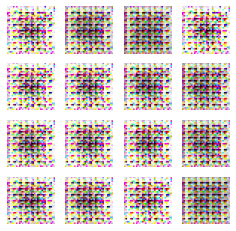

Training GAN at Time Step 1 of Epoch 43
Training GAN at Time Step 2 of Epoch 43
Training GAN at Time Step 3 of Epoch 43
Training GAN at Time Step 4 of Epoch 43
Training GAN at Time Step 5 of Epoch 43
Training GAN at Time Step 6 of Epoch 43
Training GAN at Time Step 7 of Epoch 43
Training GAN at Time Step 8 of Epoch 43
Training GAN at Time Step 9 of Epoch 43
Training GAN at Time Step 10 of Epoch 43
Training GAN at Time Step 11 of Epoch 43
Training GAN at Time Step 12 of Epoch 43
Training GAN at Time Step 13 of Epoch 43
Training GAN at Time Step 14 of Epoch 43
Training GAN at Time Step 15 of Epoch 43
Training GAN at Time Step 16 of Epoch 43
Training GAN at Time Step 17 of Epoch 43
Training GAN at Time Step 18 of Epoch 43
Training GAN at Time Step 19 of Epoch 43
Training GAN at Time Step 20 of Epoch 43
Training GAN at Time Step 21 of Epoch 43
Training GAN at Time Step 22 of Epoch 43
Training GAN at Time Step 23 of Epoch 43
Training GAN at Time Step 24 of Epoch 43
Training GAN at Time Step

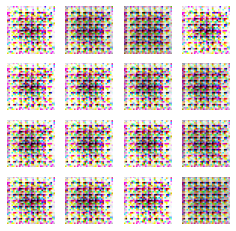

Training GAN at Time Step 1 of Epoch 44
Training GAN at Time Step 2 of Epoch 44
Training GAN at Time Step 3 of Epoch 44
Training GAN at Time Step 4 of Epoch 44
Training GAN at Time Step 5 of Epoch 44
Training GAN at Time Step 6 of Epoch 44
Training GAN at Time Step 7 of Epoch 44
Training GAN at Time Step 8 of Epoch 44
Training GAN at Time Step 9 of Epoch 44
Training GAN at Time Step 10 of Epoch 44
Training GAN at Time Step 11 of Epoch 44
Training GAN at Time Step 12 of Epoch 44
Training GAN at Time Step 13 of Epoch 44
Training GAN at Time Step 14 of Epoch 44
Training GAN at Time Step 15 of Epoch 44
Training GAN at Time Step 16 of Epoch 44
Training GAN at Time Step 17 of Epoch 44
Training GAN at Time Step 18 of Epoch 44
Training GAN at Time Step 19 of Epoch 44
Training GAN at Time Step 20 of Epoch 44
Training GAN at Time Step 21 of Epoch 44
Training GAN at Time Step 22 of Epoch 44
Training GAN at Time Step 23 of Epoch 44
Training GAN at Time Step 24 of Epoch 44
Training GAN at Time Step

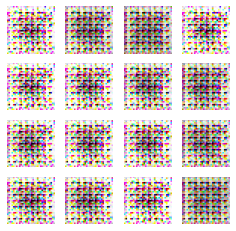

Training GAN at Time Step 1 of Epoch 45
Training GAN at Time Step 2 of Epoch 45
Training GAN at Time Step 3 of Epoch 45
Training GAN at Time Step 4 of Epoch 45
Training GAN at Time Step 5 of Epoch 45
Training GAN at Time Step 6 of Epoch 45
Training GAN at Time Step 7 of Epoch 45
Training GAN at Time Step 8 of Epoch 45
Training GAN at Time Step 9 of Epoch 45
Training GAN at Time Step 10 of Epoch 45
Training GAN at Time Step 11 of Epoch 45
Training GAN at Time Step 12 of Epoch 45
Training GAN at Time Step 13 of Epoch 45
Training GAN at Time Step 14 of Epoch 45
Training GAN at Time Step 15 of Epoch 45
Training GAN at Time Step 16 of Epoch 45
Training GAN at Time Step 17 of Epoch 45
Training GAN at Time Step 18 of Epoch 45
Training GAN at Time Step 19 of Epoch 45
Training GAN at Time Step 20 of Epoch 45
Training GAN at Time Step 21 of Epoch 45
Training GAN at Time Step 22 of Epoch 45
Training GAN at Time Step 23 of Epoch 45
Training GAN at Time Step 24 of Epoch 45
Training GAN at Time Step

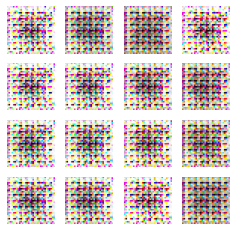

Training GAN at Time Step 1 of Epoch 46
Training GAN at Time Step 2 of Epoch 46
Training GAN at Time Step 3 of Epoch 46
Training GAN at Time Step 4 of Epoch 46
Training GAN at Time Step 5 of Epoch 46
Training GAN at Time Step 6 of Epoch 46
Training GAN at Time Step 7 of Epoch 46
Training GAN at Time Step 8 of Epoch 46
Training GAN at Time Step 9 of Epoch 46
Training GAN at Time Step 10 of Epoch 46
Training GAN at Time Step 11 of Epoch 46
Training GAN at Time Step 12 of Epoch 46
Training GAN at Time Step 13 of Epoch 46
Training GAN at Time Step 14 of Epoch 46
Training GAN at Time Step 15 of Epoch 46
Training GAN at Time Step 16 of Epoch 46
Training GAN at Time Step 17 of Epoch 46
Training GAN at Time Step 18 of Epoch 46
Training GAN at Time Step 19 of Epoch 46
Training GAN at Time Step 20 of Epoch 46
Training GAN at Time Step 21 of Epoch 46
Training GAN at Time Step 22 of Epoch 46
Training GAN at Time Step 23 of Epoch 46
Training GAN at Time Step 24 of Epoch 46
Training GAN at Time Step

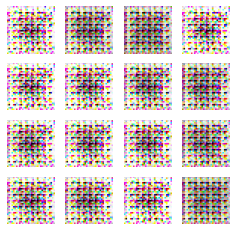

Training GAN at Time Step 1 of Epoch 47
Training GAN at Time Step 2 of Epoch 47
Training GAN at Time Step 3 of Epoch 47
Training GAN at Time Step 4 of Epoch 47
Training GAN at Time Step 5 of Epoch 47
Training GAN at Time Step 6 of Epoch 47
Training GAN at Time Step 7 of Epoch 47
Training GAN at Time Step 8 of Epoch 47
Training GAN at Time Step 9 of Epoch 47
Training GAN at Time Step 10 of Epoch 47
Training GAN at Time Step 11 of Epoch 47
Training GAN at Time Step 12 of Epoch 47
Training GAN at Time Step 13 of Epoch 47
Training GAN at Time Step 14 of Epoch 47
Training GAN at Time Step 15 of Epoch 47
Training GAN at Time Step 16 of Epoch 47
Training GAN at Time Step 17 of Epoch 47
Training GAN at Time Step 18 of Epoch 47
Training GAN at Time Step 19 of Epoch 47
Training GAN at Time Step 20 of Epoch 47
Training GAN at Time Step 21 of Epoch 47
Training GAN at Time Step 22 of Epoch 47
Training GAN at Time Step 23 of Epoch 47
Training GAN at Time Step 24 of Epoch 47
Training GAN at Time Step

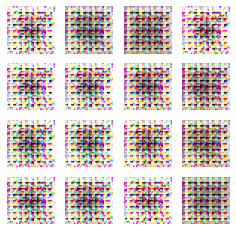

Training GAN at Time Step 1 of Epoch 48
Training GAN at Time Step 2 of Epoch 48
Training GAN at Time Step 3 of Epoch 48
Training GAN at Time Step 4 of Epoch 48
Training GAN at Time Step 5 of Epoch 48
Training GAN at Time Step 6 of Epoch 48
Training GAN at Time Step 7 of Epoch 48
Training GAN at Time Step 8 of Epoch 48
Training GAN at Time Step 9 of Epoch 48
Training GAN at Time Step 10 of Epoch 48
Training GAN at Time Step 11 of Epoch 48
Training GAN at Time Step 12 of Epoch 48
Training GAN at Time Step 13 of Epoch 48
Training GAN at Time Step 14 of Epoch 48
Training GAN at Time Step 15 of Epoch 48
Training GAN at Time Step 16 of Epoch 48
Training GAN at Time Step 17 of Epoch 48
Training GAN at Time Step 18 of Epoch 48
Training GAN at Time Step 19 of Epoch 48
Training GAN at Time Step 20 of Epoch 48
Training GAN at Time Step 21 of Epoch 48
Training GAN at Time Step 22 of Epoch 48
Training GAN at Time Step 23 of Epoch 48
Training GAN at Time Step 24 of Epoch 48
Training GAN at Time Step

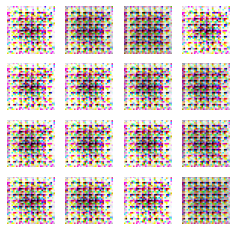

Training GAN at Time Step 1 of Epoch 49
Training GAN at Time Step 2 of Epoch 49
Training GAN at Time Step 3 of Epoch 49
Training GAN at Time Step 4 of Epoch 49
Training GAN at Time Step 5 of Epoch 49
Training GAN at Time Step 6 of Epoch 49
Training GAN at Time Step 7 of Epoch 49
Training GAN at Time Step 8 of Epoch 49
Training GAN at Time Step 9 of Epoch 49
Training GAN at Time Step 10 of Epoch 49
Training GAN at Time Step 11 of Epoch 49
Training GAN at Time Step 12 of Epoch 49
Training GAN at Time Step 13 of Epoch 49
Training GAN at Time Step 14 of Epoch 49
Training GAN at Time Step 15 of Epoch 49
Training GAN at Time Step 16 of Epoch 49
Training GAN at Time Step 17 of Epoch 49
Training GAN at Time Step 18 of Epoch 49
Training GAN at Time Step 19 of Epoch 49
Training GAN at Time Step 20 of Epoch 49
Training GAN at Time Step 21 of Epoch 49
Training GAN at Time Step 22 of Epoch 49
Training GAN at Time Step 23 of Epoch 49
Training GAN at Time Step 24 of Epoch 49
Training GAN at Time Step

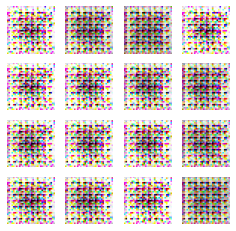

Training GAN at Time Step 1 of Epoch 50
Training GAN at Time Step 2 of Epoch 50
Training GAN at Time Step 3 of Epoch 50
Training GAN at Time Step 4 of Epoch 50
Training GAN at Time Step 5 of Epoch 50
Training GAN at Time Step 6 of Epoch 50
Training GAN at Time Step 7 of Epoch 50
Training GAN at Time Step 8 of Epoch 50
Training GAN at Time Step 9 of Epoch 50
Training GAN at Time Step 10 of Epoch 50
Training GAN at Time Step 11 of Epoch 50
Training GAN at Time Step 12 of Epoch 50
Training GAN at Time Step 13 of Epoch 50
Training GAN at Time Step 14 of Epoch 50
Training GAN at Time Step 15 of Epoch 50
Training GAN at Time Step 16 of Epoch 50
Training GAN at Time Step 17 of Epoch 50
Training GAN at Time Step 18 of Epoch 50
Training GAN at Time Step 19 of Epoch 50
Training GAN at Time Step 20 of Epoch 50
Training GAN at Time Step 21 of Epoch 50
Training GAN at Time Step 22 of Epoch 50
Training GAN at Time Step 23 of Epoch 50
Training GAN at Time Step 24 of Epoch 50
Training GAN at Time Step

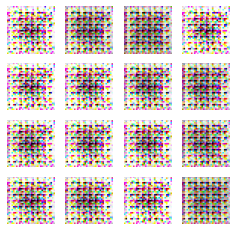

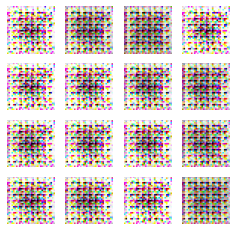

In [ ]:
train_gan(real_imgs_datagen=unlabeled_datagen,total_epochs=GAN_epochs)

In [ ]:
latest_checkpoint_path = tf.train.latest_checkpoint("/content/drive/MyDrive/Colab Notebooks/GAN_training_checkpoints")

In [ ]:
latest_checkpoint_path

'/content/drive/MyDrive/Colab Notebooks/GAN_training_checkpoints/ckpt-10'

In [ ]:
GAN_checkpoint.restore(latest_checkpoint_path)

In [ ]:
# Now we will divide the discriminator of GAN into supervised classifier and unsupervised classifier to  perform classificaton 

In [ ]:
def generate_and_save_images(generator_model,test_input):

  generated_sample_images = generator_model(test_input,training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(generated_sample_images.shape[0]):
    plt.subplot(4,4,i+1)
    plt.imshow(generated_sample_images[i,:,:,:])
    plt.axis("off")

  plt.show()

In [ ]:
def discriminator_base():

  input_to_cls = Input(shape=(32,32,3))

  disc_base = Sequential(name="disc_base")
  disc_base.add(input_to_cls)

  for layer in D.layers[0:10]:
    disc_base.add(layer)

  return disc_base

In [ ]:
def unsupervised_classifier():

  disc_base = discriminator_base()

  disc_base.add(Dense(units=1,activation="sigmoid"))

  return disc_base

In [ ]:
def supervised_classifier():

  disc_base = discriminator_base()

  disc_base.add(Dense(units=1,activation="sigmoid"))

  return disc_base

In [ ]:
unsupervised_cls = unsupervised_classifier()
supervised_cls = supervised_classifier()

In [ ]:
unsupervised_cls_optimizer = keras.optimizers.adam_v2.Adam(learning_rate=0.0001,beta_1=0.3)
supervised_cls_optimizer = keras.optimizers.adam_v2.Adam(learning_rate=0.0001,beta_1=0.3)

In [ ]:
supervised_cls_train_acc_metric = tf.keras.metrics.BinaryAccuracy()
supervised_cls_cv_acc_metric = tf.keras.metrics.BinaryAccuracy()

In [ ]:
def unsupervised_cls_loss(real_imgs_preds,fake_imgs_preds):

  real_imgs_labels = tf.ones_like(real_imgs_preds)
  fake_imgs_labels = tf.zeros_like(fake_imgs_preds)

  real_imgs_loss = bce_loss(y_true=real_imgs_labels,y_pred=real_imgs_preds)
  fake_imgs_loss = bce_loss(y_true=fake_imgs_labels,y_pred=fake_imgs_preds)

  total_loss = real_imgs_loss + fake_imgs_loss

  return total_loss

In [ ]:
def supervised_cls_loss(imgs_labels,imgs_preds):

  return bce_loss(y_true=imgs_labels,y_pred=imgs_preds)

In [ ]:
labeled_datagen = data_gen.flow_from_directory(directory="/content/drive/MyDrive/Colab Notebooks/MelanomaDetection/labeled",
                                               target_size=(32,32),classes=['benign','malignant'],batch_size=7,class_mode='binary')

Found 210 images belonging to 2 classes.


In [ ]:
labeled_batch_size = 7

In [ ]:
@tf.function
def training_step(unlabeled_mb,labeled_mb):
#This function will perform the training step of our GAN classifier.
  G.trainable = False
  #our generator will be freeze throughtout the training
  noise = tf.random.normal(shape=(batch_size,noise_shape))
  generated_imgs_mini_batch = G(noise,training=False)

  with tf.GradientTape() as unsupervised_tape, tf.GradientTape() as supervised_tape:

      unsupervised_cls.trainable = True
      #pass the mini batches of unlabeled and generated images through unsupervised classifier

      real_imgs_preds = unsupervised_cls(unlabeled_mb,training=True)
      fake_imgs_preds = unsupervised_cls(generated_imgs_mini_batch,training=True)

      unsupervised_loss = unsupervised_cls_loss(real_imgs_preds,fake_imgs_preds)
      #computing the loss of unsupervised classifier

      gradients_of_unsupervised = unsupervised_tape.gradient(unsupervised_loss,unsupervised_cls.trainable_variables)
      unsupervised_cls_optimizer.apply_gradients(zip(gradients_of_unsupervised,unsupervised_cls.trainable_variables))
      #applying backpropagation to minimize the loss

      supervised_cls.trainable = True
      #pass the mini batch of labeled images through supervised classifier
        
      labeled_imgs_preds = supervised_cls(labeled_mb[0],training=True)
      real_labels = labeled_mb[1]
        
      supervised_loss = supervised_cls_loss(real_labels,labeled_imgs_preds)
      #computing the loss of supervised classifier
        
      gradients_of_supervised = supervised_tape.gradient(supervised_loss,supervised_cls.trainable_variables)
      supervised_cls_optimizer.apply_gradients(zip(gradients_of_supervised,supervised_cls.trainable_variables))
      #applying backpropagation to minimize the loss   

      #this function will return the predictions of unlabeled and labeled images and mini batch of generated images
      return real_imgs_preds,labeled_imgs_preds,generated_imgs_mini_batch   

In [ ]:
supervised_accuracy = tf.keras.metrics.BinaryAccuracy()
unsupervised_accuracy = tf.keras.metrics.BinaryAccuracy()

In [ ]:
def train_classifier(unlabeled_img_datagen,labeled_img_datagen,total_epochs):
#this function will train classifier and calculate accuracy for total_epochs
  for epoch in range(total_epochs):

    time_step = 1

    for labeled_image_batch,unlabeled_image_batch in zip(labeled_img_datagen,unlabeled_img_datagen):

      print("Training GAN classifier at Time Step {} of Epoch {}".format(time_step,epoch+1))
      real_imgs_preds,labeled_imgs_preds,generated_imgs_mini_batch = training_step(unlabeled_mb=unlabeled_image_batch[0],labeled_mb=labeled_image_batch)

      if time_step > len(os.listdir(real_imgs_path))//batch_size:
        break

      time_step = time_step + 1

    plt.imshow(generated_imgs_mini_batch[0,:,:,:])
    plt.show()
    
    #computing accuracy for supervised and unsupervised classifier
    unsupervised_accuracy.update_state(unlabeled_image_batch[1],real_imgs_preds)
    supervised_accuracy.update_state(labeled_image_batch[1],labeled_imgs_preds)
    print('unsupervised_accuracy:{}'.format(unsupervised_accuracy.result()))
    print('supervised_accuracy:{}'.format(supervised_accuracy.result()))

  generate_and_save_images(generator_model=G,test_input=constant_noise)

Training GAN at Time Step 1 of Epoch 1
Training GAN at Time Step 2 of Epoch 1
Training GAN at Time Step 3 of Epoch 1
Training GAN at Time Step 4 of Epoch 1
Training GAN at Time Step 5 of Epoch 1
Training GAN at Time Step 6 of Epoch 1
Training GAN at Time Step 7 of Epoch 1
Training GAN at Time Step 8 of Epoch 1
Training GAN at Time Step 9 of Epoch 1
Training GAN at Time Step 10 of Epoch 1
Training GAN at Time Step 11 of Epoch 1
Training GAN at Time Step 12 of Epoch 1
Training GAN at Time Step 13 of Epoch 1
Training GAN at Time Step 14 of Epoch 1
Training GAN at Time Step 15 of Epoch 1
Training GAN at Time Step 16 of Epoch 1
Training GAN at Time Step 17 of Epoch 1
Training GAN at Time Step 18 of Epoch 1
Training GAN at Time Step 19 of Epoch 1
Training GAN at Time Step 20 of Epoch 1
Training GAN at Time Step 21 of Epoch 1
Training GAN at Time Step 22 of Epoch 1
Training GAN at Time Step 23 of Epoch 1
Training GAN at Time Step 24 of Epoch 1
Training GAN at Time Step 25 of Epoch 1
Training 

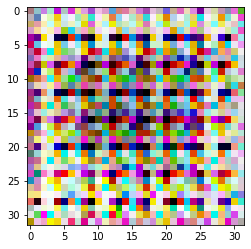

unsupervised_accuracy:1.0
supervised_accuracy:0.5357142686843872
Training GAN at Time Step 1 of Epoch 2
Training GAN at Time Step 2 of Epoch 2
Training GAN at Time Step 3 of Epoch 2
Training GAN at Time Step 4 of Epoch 2
Training GAN at Time Step 5 of Epoch 2
Training GAN at Time Step 6 of Epoch 2
Training GAN at Time Step 7 of Epoch 2
Training GAN at Time Step 8 of Epoch 2
Training GAN at Time Step 9 of Epoch 2
Training GAN at Time Step 10 of Epoch 2
Training GAN at Time Step 11 of Epoch 2
Training GAN at Time Step 12 of Epoch 2
Training GAN at Time Step 13 of Epoch 2
Training GAN at Time Step 14 of Epoch 2
Training GAN at Time Step 15 of Epoch 2
Training GAN at Time Step 16 of Epoch 2
Training GAN at Time Step 17 of Epoch 2
Training GAN at Time Step 18 of Epoch 2
Training GAN at Time Step 19 of Epoch 2
Training GAN at Time Step 20 of Epoch 2
Training GAN at Time Step 21 of Epoch 2
Training GAN at Time Step 22 of Epoch 2
Training GAN at Time Step 23 of Epoch 2
Training GAN at Time Ste

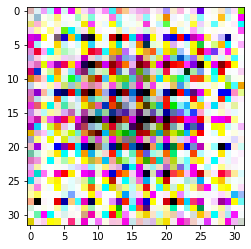

unsupervised_accuracy:1.0
supervised_accuracy:0.6000000238418579
Training GAN at Time Step 1 of Epoch 3
Training GAN at Time Step 2 of Epoch 3
Training GAN at Time Step 3 of Epoch 3
Training GAN at Time Step 4 of Epoch 3
Training GAN at Time Step 5 of Epoch 3
Training GAN at Time Step 6 of Epoch 3
Training GAN at Time Step 7 of Epoch 3
Training GAN at Time Step 8 of Epoch 3
Training GAN at Time Step 9 of Epoch 3
Training GAN at Time Step 10 of Epoch 3
Training GAN at Time Step 11 of Epoch 3
Training GAN at Time Step 12 of Epoch 3
Training GAN at Time Step 13 of Epoch 3
Training GAN at Time Step 14 of Epoch 3
Training GAN at Time Step 15 of Epoch 3
Training GAN at Time Step 16 of Epoch 3
Training GAN at Time Step 17 of Epoch 3
Training GAN at Time Step 18 of Epoch 3
Training GAN at Time Step 19 of Epoch 3
Training GAN at Time Step 20 of Epoch 3
Training GAN at Time Step 21 of Epoch 3
Training GAN at Time Step 22 of Epoch 3
Training GAN at Time Step 23 of Epoch 3
Training GAN at Time Ste

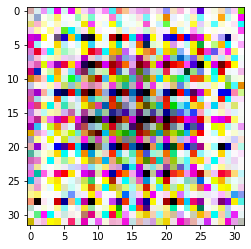

unsupervised_accuracy:1.0
supervised_accuracy:0.523809552192688
Training GAN at Time Step 1 of Epoch 4
Training GAN at Time Step 2 of Epoch 4
Training GAN at Time Step 3 of Epoch 4
Training GAN at Time Step 4 of Epoch 4
Training GAN at Time Step 5 of Epoch 4
Training GAN at Time Step 6 of Epoch 4
Training GAN at Time Step 7 of Epoch 4
Training GAN at Time Step 8 of Epoch 4
Training GAN at Time Step 9 of Epoch 4
Training GAN at Time Step 10 of Epoch 4
Training GAN at Time Step 11 of Epoch 4
Training GAN at Time Step 12 of Epoch 4
Training GAN at Time Step 13 of Epoch 4
Training GAN at Time Step 14 of Epoch 4
Training GAN at Time Step 15 of Epoch 4
Training GAN at Time Step 16 of Epoch 4
Training GAN at Time Step 17 of Epoch 4
Training GAN at Time Step 18 of Epoch 4
Training GAN at Time Step 19 of Epoch 4
Training GAN at Time Step 20 of Epoch 4
Training GAN at Time Step 21 of Epoch 4
Training GAN at Time Step 22 of Epoch 4
Training GAN at Time Step 23 of Epoch 4
Training GAN at Time Step

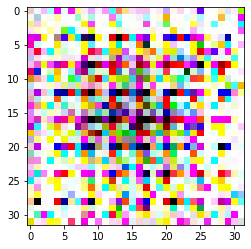

unsupervised_accuracy:1.0
supervised_accuracy:0.5102040767669678
Training GAN at Time Step 1 of Epoch 5
Training GAN at Time Step 2 of Epoch 5
Training GAN at Time Step 3 of Epoch 5
Training GAN at Time Step 4 of Epoch 5
Training GAN at Time Step 5 of Epoch 5
Training GAN at Time Step 6 of Epoch 5
Training GAN at Time Step 7 of Epoch 5
Training GAN at Time Step 8 of Epoch 5
Training GAN at Time Step 9 of Epoch 5
Training GAN at Time Step 10 of Epoch 5
Training GAN at Time Step 11 of Epoch 5
Training GAN at Time Step 12 of Epoch 5
Training GAN at Time Step 13 of Epoch 5
Training GAN at Time Step 14 of Epoch 5
Training GAN at Time Step 15 of Epoch 5
Training GAN at Time Step 16 of Epoch 5
Training GAN at Time Step 17 of Epoch 5
Training GAN at Time Step 18 of Epoch 5
Training GAN at Time Step 19 of Epoch 5
Training GAN at Time Step 20 of Epoch 5
Training GAN at Time Step 21 of Epoch 5
Training GAN at Time Step 22 of Epoch 5
Training GAN at Time Step 23 of Epoch 5
Training GAN at Time Ste

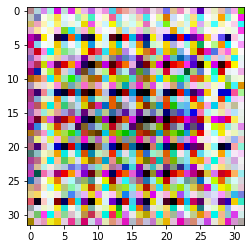

unsupervised_accuracy:1.0
supervised_accuracy:0.5178571343421936
Training GAN at Time Step 1 of Epoch 6
Training GAN at Time Step 2 of Epoch 6
Training GAN at Time Step 3 of Epoch 6
Training GAN at Time Step 4 of Epoch 6
Training GAN at Time Step 5 of Epoch 6
Training GAN at Time Step 6 of Epoch 6
Training GAN at Time Step 7 of Epoch 6
Training GAN at Time Step 8 of Epoch 6
Training GAN at Time Step 9 of Epoch 6
Training GAN at Time Step 10 of Epoch 6
Training GAN at Time Step 11 of Epoch 6
Training GAN at Time Step 12 of Epoch 6
Training GAN at Time Step 13 of Epoch 6
Training GAN at Time Step 14 of Epoch 6
Training GAN at Time Step 15 of Epoch 6
Training GAN at Time Step 16 of Epoch 6
Training GAN at Time Step 17 of Epoch 6
Training GAN at Time Step 18 of Epoch 6
Training GAN at Time Step 19 of Epoch 6
Training GAN at Time Step 20 of Epoch 6
Training GAN at Time Step 21 of Epoch 6
Training GAN at Time Step 22 of Epoch 6
Training GAN at Time Step 23 of Epoch 6
Training GAN at Time Ste

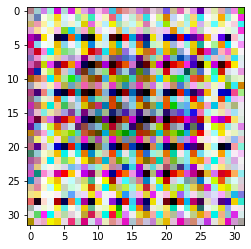

unsupervised_accuracy:1.0
supervised_accuracy:0.523809552192688
Training GAN at Time Step 1 of Epoch 7
Training GAN at Time Step 2 of Epoch 7
Training GAN at Time Step 3 of Epoch 7
Training GAN at Time Step 4 of Epoch 7
Training GAN at Time Step 5 of Epoch 7
Training GAN at Time Step 6 of Epoch 7
Training GAN at Time Step 7 of Epoch 7
Training GAN at Time Step 8 of Epoch 7
Training GAN at Time Step 9 of Epoch 7
Training GAN at Time Step 10 of Epoch 7
Training GAN at Time Step 11 of Epoch 7
Training GAN at Time Step 12 of Epoch 7
Training GAN at Time Step 13 of Epoch 7
Training GAN at Time Step 14 of Epoch 7
Training GAN at Time Step 15 of Epoch 7
Training GAN at Time Step 16 of Epoch 7
Training GAN at Time Step 17 of Epoch 7
Training GAN at Time Step 18 of Epoch 7
Training GAN at Time Step 19 of Epoch 7
Training GAN at Time Step 20 of Epoch 7
Training GAN at Time Step 21 of Epoch 7
Training GAN at Time Step 22 of Epoch 7
Training GAN at Time Step 23 of Epoch 7
Training GAN at Time Step

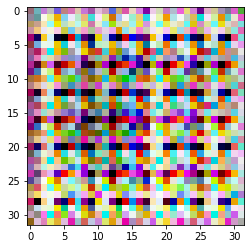

unsupervised_accuracy:1.0
supervised_accuracy:0.5571428537368774
Training GAN at Time Step 1 of Epoch 8
Training GAN at Time Step 2 of Epoch 8
Training GAN at Time Step 3 of Epoch 8
Training GAN at Time Step 4 of Epoch 8
Training GAN at Time Step 5 of Epoch 8
Training GAN at Time Step 6 of Epoch 8
Training GAN at Time Step 7 of Epoch 8
Training GAN at Time Step 8 of Epoch 8
Training GAN at Time Step 9 of Epoch 8
Training GAN at Time Step 10 of Epoch 8
Training GAN at Time Step 11 of Epoch 8
Training GAN at Time Step 12 of Epoch 8
Training GAN at Time Step 13 of Epoch 8
Training GAN at Time Step 14 of Epoch 8
Training GAN at Time Step 15 of Epoch 8
Training GAN at Time Step 16 of Epoch 8
Training GAN at Time Step 17 of Epoch 8
Training GAN at Time Step 18 of Epoch 8
Training GAN at Time Step 19 of Epoch 8
Training GAN at Time Step 20 of Epoch 8
Training GAN at Time Step 21 of Epoch 8
Training GAN at Time Step 22 of Epoch 8
Training GAN at Time Step 23 of Epoch 8
Training GAN at Time Ste

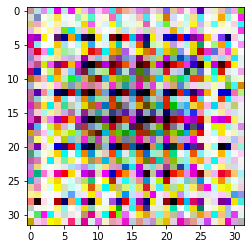

unsupervised_accuracy:1.0
supervised_accuracy:0.5584415793418884
Training GAN at Time Step 1 of Epoch 9
Training GAN at Time Step 2 of Epoch 9
Training GAN at Time Step 3 of Epoch 9
Training GAN at Time Step 4 of Epoch 9
Training GAN at Time Step 5 of Epoch 9
Training GAN at Time Step 6 of Epoch 9
Training GAN at Time Step 7 of Epoch 9
Training GAN at Time Step 8 of Epoch 9
Training GAN at Time Step 9 of Epoch 9
Training GAN at Time Step 10 of Epoch 9
Training GAN at Time Step 11 of Epoch 9
Training GAN at Time Step 12 of Epoch 9
Training GAN at Time Step 13 of Epoch 9
Training GAN at Time Step 14 of Epoch 9
Training GAN at Time Step 15 of Epoch 9
Training GAN at Time Step 16 of Epoch 9
Training GAN at Time Step 17 of Epoch 9
Training GAN at Time Step 18 of Epoch 9
Training GAN at Time Step 19 of Epoch 9
Training GAN at Time Step 20 of Epoch 9
Training GAN at Time Step 21 of Epoch 9
Training GAN at Time Step 22 of Epoch 9
Training GAN at Time Step 23 of Epoch 9
Training GAN at Time Ste

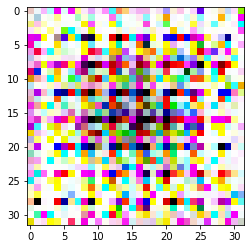

unsupervised_accuracy:1.0
supervised_accuracy:0.5833333134651184
Training GAN at Time Step 1 of Epoch 10
Training GAN at Time Step 2 of Epoch 10
Training GAN at Time Step 3 of Epoch 10
Training GAN at Time Step 4 of Epoch 10
Training GAN at Time Step 5 of Epoch 10
Training GAN at Time Step 6 of Epoch 10
Training GAN at Time Step 7 of Epoch 10
Training GAN at Time Step 8 of Epoch 10
Training GAN at Time Step 9 of Epoch 10
Training GAN at Time Step 10 of Epoch 10
Training GAN at Time Step 11 of Epoch 10
Training GAN at Time Step 12 of Epoch 10
Training GAN at Time Step 13 of Epoch 10
Training GAN at Time Step 14 of Epoch 10
Training GAN at Time Step 15 of Epoch 10
Training GAN at Time Step 16 of Epoch 10
Training GAN at Time Step 17 of Epoch 10
Training GAN at Time Step 18 of Epoch 10
Training GAN at Time Step 19 of Epoch 10
Training GAN at Time Step 20 of Epoch 10
Training GAN at Time Step 21 of Epoch 10
Training GAN at Time Step 22 of Epoch 10
Training GAN at Time Step 23 of Epoch 10
T

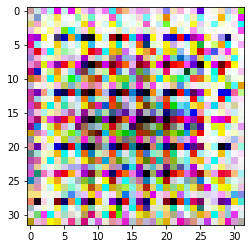

unsupervised_accuracy:1.0
supervised_accuracy:0.5824176073074341
Training GAN at Time Step 1 of Epoch 11
Training GAN at Time Step 2 of Epoch 11
Training GAN at Time Step 3 of Epoch 11
Training GAN at Time Step 4 of Epoch 11
Training GAN at Time Step 5 of Epoch 11
Training GAN at Time Step 6 of Epoch 11
Training GAN at Time Step 7 of Epoch 11
Training GAN at Time Step 8 of Epoch 11
Training GAN at Time Step 9 of Epoch 11
Training GAN at Time Step 10 of Epoch 11
Training GAN at Time Step 11 of Epoch 11
Training GAN at Time Step 12 of Epoch 11
Training GAN at Time Step 13 of Epoch 11
Training GAN at Time Step 14 of Epoch 11
Training GAN at Time Step 15 of Epoch 11
Training GAN at Time Step 16 of Epoch 11
Training GAN at Time Step 17 of Epoch 11
Training GAN at Time Step 18 of Epoch 11
Training GAN at Time Step 19 of Epoch 11
Training GAN at Time Step 20 of Epoch 11
Training GAN at Time Step 21 of Epoch 11
Training GAN at Time Step 22 of Epoch 11
Training GAN at Time Step 23 of Epoch 11
T

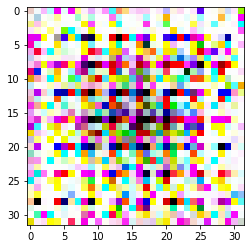

unsupervised_accuracy:1.0
supervised_accuracy:0.5918367505073547
Training GAN at Time Step 1 of Epoch 12
Training GAN at Time Step 2 of Epoch 12
Training GAN at Time Step 3 of Epoch 12
Training GAN at Time Step 4 of Epoch 12
Training GAN at Time Step 5 of Epoch 12
Training GAN at Time Step 6 of Epoch 12
Training GAN at Time Step 7 of Epoch 12
Training GAN at Time Step 8 of Epoch 12
Training GAN at Time Step 9 of Epoch 12
Training GAN at Time Step 10 of Epoch 12
Training GAN at Time Step 11 of Epoch 12
Training GAN at Time Step 12 of Epoch 12
Training GAN at Time Step 13 of Epoch 12
Training GAN at Time Step 14 of Epoch 12
Training GAN at Time Step 15 of Epoch 12
Training GAN at Time Step 16 of Epoch 12
Training GAN at Time Step 17 of Epoch 12
Training GAN at Time Step 18 of Epoch 12
Training GAN at Time Step 19 of Epoch 12
Training GAN at Time Step 20 of Epoch 12
Training GAN at Time Step 21 of Epoch 12
Training GAN at Time Step 22 of Epoch 12
Training GAN at Time Step 23 of Epoch 12
T

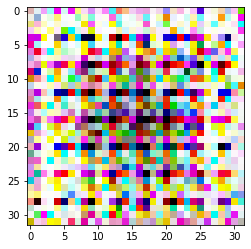

unsupervised_accuracy:1.0
supervised_accuracy:0.6095238327980042
Training GAN at Time Step 1 of Epoch 13
Training GAN at Time Step 2 of Epoch 13
Training GAN at Time Step 3 of Epoch 13
Training GAN at Time Step 4 of Epoch 13
Training GAN at Time Step 5 of Epoch 13
Training GAN at Time Step 6 of Epoch 13
Training GAN at Time Step 7 of Epoch 13
Training GAN at Time Step 8 of Epoch 13
Training GAN at Time Step 9 of Epoch 13
Training GAN at Time Step 10 of Epoch 13
Training GAN at Time Step 11 of Epoch 13
Training GAN at Time Step 12 of Epoch 13
Training GAN at Time Step 13 of Epoch 13
Training GAN at Time Step 14 of Epoch 13
Training GAN at Time Step 15 of Epoch 13
Training GAN at Time Step 16 of Epoch 13
Training GAN at Time Step 17 of Epoch 13
Training GAN at Time Step 18 of Epoch 13
Training GAN at Time Step 19 of Epoch 13
Training GAN at Time Step 20 of Epoch 13
Training GAN at Time Step 21 of Epoch 13
Training GAN at Time Step 22 of Epoch 13
Training GAN at Time Step 23 of Epoch 13
T

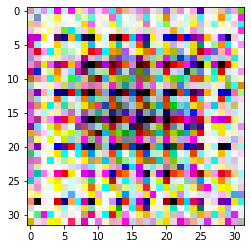

unsupervised_accuracy:1.0
supervised_accuracy:0.6160714030265808
Training GAN at Time Step 1 of Epoch 14
Training GAN at Time Step 2 of Epoch 14
Training GAN at Time Step 3 of Epoch 14
Training GAN at Time Step 4 of Epoch 14
Training GAN at Time Step 5 of Epoch 14
Training GAN at Time Step 6 of Epoch 14
Training GAN at Time Step 7 of Epoch 14
Training GAN at Time Step 8 of Epoch 14
Training GAN at Time Step 9 of Epoch 14
Training GAN at Time Step 10 of Epoch 14
Training GAN at Time Step 11 of Epoch 14
Training GAN at Time Step 12 of Epoch 14
Training GAN at Time Step 13 of Epoch 14
Training GAN at Time Step 14 of Epoch 14
Training GAN at Time Step 15 of Epoch 14
Training GAN at Time Step 16 of Epoch 14
Training GAN at Time Step 17 of Epoch 14
Training GAN at Time Step 18 of Epoch 14
Training GAN at Time Step 19 of Epoch 14
Training GAN at Time Step 20 of Epoch 14
Training GAN at Time Step 21 of Epoch 14
Training GAN at Time Step 22 of Epoch 14
Training GAN at Time Step 23 of Epoch 14
T

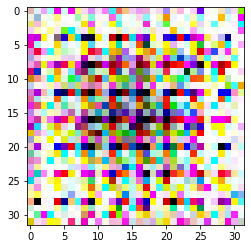

unsupervised_accuracy:1.0
supervised_accuracy:0.6134454011917114
Training GAN at Time Step 1 of Epoch 15
Training GAN at Time Step 2 of Epoch 15
Training GAN at Time Step 3 of Epoch 15
Training GAN at Time Step 4 of Epoch 15
Training GAN at Time Step 5 of Epoch 15
Training GAN at Time Step 6 of Epoch 15
Training GAN at Time Step 7 of Epoch 15
Training GAN at Time Step 8 of Epoch 15
Training GAN at Time Step 9 of Epoch 15
Training GAN at Time Step 10 of Epoch 15
Training GAN at Time Step 11 of Epoch 15
Training GAN at Time Step 12 of Epoch 15
Training GAN at Time Step 13 of Epoch 15
Training GAN at Time Step 14 of Epoch 15
Training GAN at Time Step 15 of Epoch 15
Training GAN at Time Step 16 of Epoch 15
Training GAN at Time Step 17 of Epoch 15
Training GAN at Time Step 18 of Epoch 15
Training GAN at Time Step 19 of Epoch 15
Training GAN at Time Step 20 of Epoch 15
Training GAN at Time Step 21 of Epoch 15
Training GAN at Time Step 22 of Epoch 15
Training GAN at Time Step 23 of Epoch 15
T

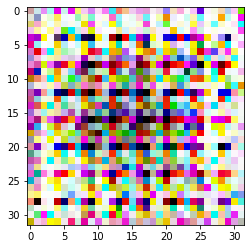

unsupervised_accuracy:1.0
supervised_accuracy:0.6111111044883728
Training GAN at Time Step 1 of Epoch 16
Training GAN at Time Step 2 of Epoch 16
Training GAN at Time Step 3 of Epoch 16
Training GAN at Time Step 4 of Epoch 16
Training GAN at Time Step 5 of Epoch 16
Training GAN at Time Step 6 of Epoch 16
Training GAN at Time Step 7 of Epoch 16
Training GAN at Time Step 8 of Epoch 16
Training GAN at Time Step 9 of Epoch 16
Training GAN at Time Step 10 of Epoch 16
Training GAN at Time Step 11 of Epoch 16
Training GAN at Time Step 12 of Epoch 16
Training GAN at Time Step 13 of Epoch 16
Training GAN at Time Step 14 of Epoch 16
Training GAN at Time Step 15 of Epoch 16
Training GAN at Time Step 16 of Epoch 16
Training GAN at Time Step 17 of Epoch 16
Training GAN at Time Step 18 of Epoch 16
Training GAN at Time Step 19 of Epoch 16
Training GAN at Time Step 20 of Epoch 16
Training GAN at Time Step 21 of Epoch 16
Training GAN at Time Step 22 of Epoch 16
Training GAN at Time Step 23 of Epoch 16
T

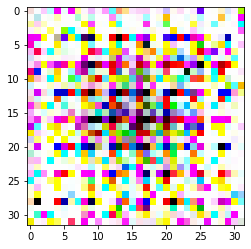

unsupervised_accuracy:1.0
supervised_accuracy:0.6090225577354431
Training GAN at Time Step 1 of Epoch 17
Training GAN at Time Step 2 of Epoch 17
Training GAN at Time Step 3 of Epoch 17
Training GAN at Time Step 4 of Epoch 17
Training GAN at Time Step 5 of Epoch 17
Training GAN at Time Step 6 of Epoch 17
Training GAN at Time Step 7 of Epoch 17
Training GAN at Time Step 8 of Epoch 17
Training GAN at Time Step 9 of Epoch 17
Training GAN at Time Step 10 of Epoch 17
Training GAN at Time Step 11 of Epoch 17
Training GAN at Time Step 12 of Epoch 17
Training GAN at Time Step 13 of Epoch 17
Training GAN at Time Step 14 of Epoch 17
Training GAN at Time Step 15 of Epoch 17
Training GAN at Time Step 16 of Epoch 17
Training GAN at Time Step 17 of Epoch 17
Training GAN at Time Step 18 of Epoch 17
Training GAN at Time Step 19 of Epoch 17
Training GAN at Time Step 20 of Epoch 17
Training GAN at Time Step 21 of Epoch 17
Training GAN at Time Step 22 of Epoch 17
Training GAN at Time Step 23 of Epoch 17
T

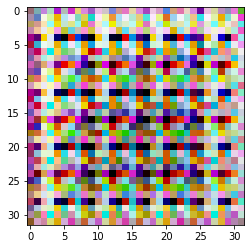

unsupervised_accuracy:1.0
supervised_accuracy:0.6142857074737549
Training GAN at Time Step 1 of Epoch 18
Training GAN at Time Step 2 of Epoch 18
Training GAN at Time Step 3 of Epoch 18
Training GAN at Time Step 4 of Epoch 18
Training GAN at Time Step 5 of Epoch 18
Training GAN at Time Step 6 of Epoch 18
Training GAN at Time Step 7 of Epoch 18
Training GAN at Time Step 8 of Epoch 18
Training GAN at Time Step 9 of Epoch 18
Training GAN at Time Step 10 of Epoch 18
Training GAN at Time Step 11 of Epoch 18
Training GAN at Time Step 12 of Epoch 18
Training GAN at Time Step 13 of Epoch 18
Training GAN at Time Step 14 of Epoch 18
Training GAN at Time Step 15 of Epoch 18
Training GAN at Time Step 16 of Epoch 18
Training GAN at Time Step 17 of Epoch 18
Training GAN at Time Step 18 of Epoch 18
Training GAN at Time Step 19 of Epoch 18
Training GAN at Time Step 20 of Epoch 18
Training GAN at Time Step 21 of Epoch 18
Training GAN at Time Step 22 of Epoch 18
Training GAN at Time Step 23 of Epoch 18
T

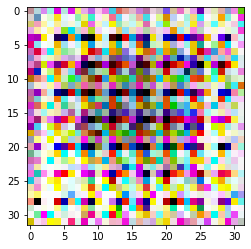

unsupervised_accuracy:1.0
supervised_accuracy:0.6122449040412903
Training GAN at Time Step 1 of Epoch 19
Training GAN at Time Step 2 of Epoch 19
Training GAN at Time Step 3 of Epoch 19
Training GAN at Time Step 4 of Epoch 19
Training GAN at Time Step 5 of Epoch 19
Training GAN at Time Step 6 of Epoch 19
Training GAN at Time Step 7 of Epoch 19
Training GAN at Time Step 8 of Epoch 19
Training GAN at Time Step 9 of Epoch 19
Training GAN at Time Step 10 of Epoch 19
Training GAN at Time Step 11 of Epoch 19
Training GAN at Time Step 12 of Epoch 19
Training GAN at Time Step 13 of Epoch 19
Training GAN at Time Step 14 of Epoch 19
Training GAN at Time Step 15 of Epoch 19
Training GAN at Time Step 16 of Epoch 19
Training GAN at Time Step 17 of Epoch 19
Training GAN at Time Step 18 of Epoch 19
Training GAN at Time Step 19 of Epoch 19
Training GAN at Time Step 20 of Epoch 19
Training GAN at Time Step 21 of Epoch 19
Training GAN at Time Step 22 of Epoch 19
Training GAN at Time Step 23 of Epoch 19
T

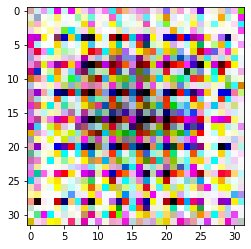

unsupervised_accuracy:1.0
supervised_accuracy:0.6103895902633667
Training GAN at Time Step 1 of Epoch 20
Training GAN at Time Step 2 of Epoch 20
Training GAN at Time Step 3 of Epoch 20
Training GAN at Time Step 4 of Epoch 20
Training GAN at Time Step 5 of Epoch 20
Training GAN at Time Step 6 of Epoch 20
Training GAN at Time Step 7 of Epoch 20
Training GAN at Time Step 8 of Epoch 20
Training GAN at Time Step 9 of Epoch 20
Training GAN at Time Step 10 of Epoch 20
Training GAN at Time Step 11 of Epoch 20
Training GAN at Time Step 12 of Epoch 20
Training GAN at Time Step 13 of Epoch 20
Training GAN at Time Step 14 of Epoch 20
Training GAN at Time Step 15 of Epoch 20
Training GAN at Time Step 16 of Epoch 20
Training GAN at Time Step 17 of Epoch 20
Training GAN at Time Step 18 of Epoch 20
Training GAN at Time Step 19 of Epoch 20
Training GAN at Time Step 20 of Epoch 20
Training GAN at Time Step 21 of Epoch 20
Training GAN at Time Step 22 of Epoch 20
Training GAN at Time Step 23 of Epoch 20
T

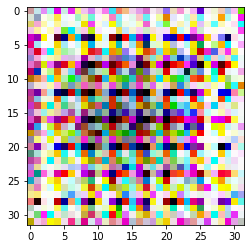

unsupervised_accuracy:1.0
supervised_accuracy:0.6149068474769592
Training GAN at Time Step 1 of Epoch 21
Training GAN at Time Step 2 of Epoch 21
Training GAN at Time Step 3 of Epoch 21
Training GAN at Time Step 4 of Epoch 21
Training GAN at Time Step 5 of Epoch 21
Training GAN at Time Step 6 of Epoch 21
Training GAN at Time Step 7 of Epoch 21
Training GAN at Time Step 8 of Epoch 21
Training GAN at Time Step 9 of Epoch 21
Training GAN at Time Step 10 of Epoch 21
Training GAN at Time Step 11 of Epoch 21
Training GAN at Time Step 12 of Epoch 21
Training GAN at Time Step 13 of Epoch 21
Training GAN at Time Step 14 of Epoch 21
Training GAN at Time Step 15 of Epoch 21
Training GAN at Time Step 16 of Epoch 21
Training GAN at Time Step 17 of Epoch 21
Training GAN at Time Step 18 of Epoch 21
Training GAN at Time Step 19 of Epoch 21
Training GAN at Time Step 20 of Epoch 21
Training GAN at Time Step 21 of Epoch 21
Training GAN at Time Step 22 of Epoch 21
Training GAN at Time Step 23 of Epoch 21
T

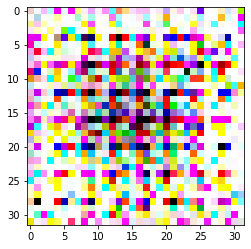

unsupervised_accuracy:1.0
supervised_accuracy:0.613095223903656
Training GAN at Time Step 1 of Epoch 22
Training GAN at Time Step 2 of Epoch 22
Training GAN at Time Step 3 of Epoch 22
Training GAN at Time Step 4 of Epoch 22
Training GAN at Time Step 5 of Epoch 22
Training GAN at Time Step 6 of Epoch 22
Training GAN at Time Step 7 of Epoch 22
Training GAN at Time Step 8 of Epoch 22
Training GAN at Time Step 9 of Epoch 22
Training GAN at Time Step 10 of Epoch 22
Training GAN at Time Step 11 of Epoch 22
Training GAN at Time Step 12 of Epoch 22
Training GAN at Time Step 13 of Epoch 22
Training GAN at Time Step 14 of Epoch 22
Training GAN at Time Step 15 of Epoch 22
Training GAN at Time Step 16 of Epoch 22
Training GAN at Time Step 17 of Epoch 22
Training GAN at Time Step 18 of Epoch 22
Training GAN at Time Step 19 of Epoch 22
Training GAN at Time Step 20 of Epoch 22
Training GAN at Time Step 21 of Epoch 22
Training GAN at Time Step 22 of Epoch 22
Training GAN at Time Step 23 of Epoch 22
Tr

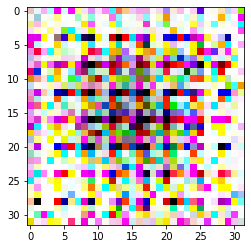

unsupervised_accuracy:1.0
supervised_accuracy:0.6171428561210632
Training GAN at Time Step 1 of Epoch 23
Training GAN at Time Step 2 of Epoch 23
Training GAN at Time Step 3 of Epoch 23
Training GAN at Time Step 4 of Epoch 23
Training GAN at Time Step 5 of Epoch 23
Training GAN at Time Step 6 of Epoch 23
Training GAN at Time Step 7 of Epoch 23
Training GAN at Time Step 8 of Epoch 23
Training GAN at Time Step 9 of Epoch 23
Training GAN at Time Step 10 of Epoch 23
Training GAN at Time Step 11 of Epoch 23
Training GAN at Time Step 12 of Epoch 23
Training GAN at Time Step 13 of Epoch 23
Training GAN at Time Step 14 of Epoch 23
Training GAN at Time Step 15 of Epoch 23
Training GAN at Time Step 16 of Epoch 23
Training GAN at Time Step 17 of Epoch 23
Training GAN at Time Step 18 of Epoch 23
Training GAN at Time Step 19 of Epoch 23
Training GAN at Time Step 20 of Epoch 23
Training GAN at Time Step 21 of Epoch 23
Training GAN at Time Step 22 of Epoch 23
Training GAN at Time Step 23 of Epoch 23
T

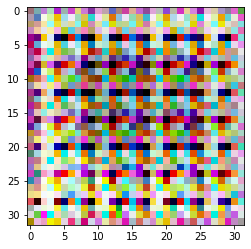

unsupervised_accuracy:1.0
supervised_accuracy:0.6263736486434937
Training GAN at Time Step 1 of Epoch 24
Training GAN at Time Step 2 of Epoch 24
Training GAN at Time Step 3 of Epoch 24
Training GAN at Time Step 4 of Epoch 24
Training GAN at Time Step 5 of Epoch 24
Training GAN at Time Step 6 of Epoch 24
Training GAN at Time Step 7 of Epoch 24
Training GAN at Time Step 8 of Epoch 24
Training GAN at Time Step 9 of Epoch 24
Training GAN at Time Step 10 of Epoch 24
Training GAN at Time Step 11 of Epoch 24
Training GAN at Time Step 12 of Epoch 24
Training GAN at Time Step 13 of Epoch 24
Training GAN at Time Step 14 of Epoch 24
Training GAN at Time Step 15 of Epoch 24
Training GAN at Time Step 16 of Epoch 24
Training GAN at Time Step 17 of Epoch 24
Training GAN at Time Step 18 of Epoch 24
Training GAN at Time Step 19 of Epoch 24
Training GAN at Time Step 20 of Epoch 24
Training GAN at Time Step 21 of Epoch 24
Training GAN at Time Step 22 of Epoch 24
Training GAN at Time Step 23 of Epoch 24
T

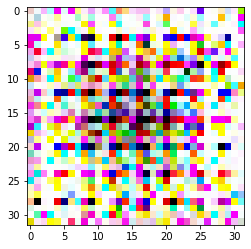

unsupervised_accuracy:1.0
supervised_accuracy:0.6349206566810608
Training GAN at Time Step 1 of Epoch 25
Training GAN at Time Step 2 of Epoch 25
Training GAN at Time Step 3 of Epoch 25
Training GAN at Time Step 4 of Epoch 25
Training GAN at Time Step 5 of Epoch 25
Training GAN at Time Step 6 of Epoch 25
Training GAN at Time Step 7 of Epoch 25
Training GAN at Time Step 8 of Epoch 25
Training GAN at Time Step 9 of Epoch 25
Training GAN at Time Step 10 of Epoch 25
Training GAN at Time Step 11 of Epoch 25
Training GAN at Time Step 12 of Epoch 25
Training GAN at Time Step 13 of Epoch 25
Training GAN at Time Step 14 of Epoch 25
Training GAN at Time Step 15 of Epoch 25
Training GAN at Time Step 16 of Epoch 25
Training GAN at Time Step 17 of Epoch 25
Training GAN at Time Step 18 of Epoch 25
Training GAN at Time Step 19 of Epoch 25
Training GAN at Time Step 20 of Epoch 25
Training GAN at Time Step 21 of Epoch 25
Training GAN at Time Step 22 of Epoch 25
Training GAN at Time Step 23 of Epoch 25
T

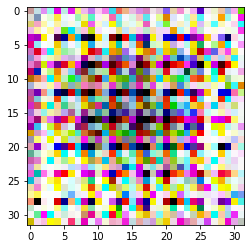

unsupervised_accuracy:1.0
supervised_accuracy:0.6377550959587097
Training GAN at Time Step 1 of Epoch 26
Training GAN at Time Step 2 of Epoch 26
Training GAN at Time Step 3 of Epoch 26
Training GAN at Time Step 4 of Epoch 26
Training GAN at Time Step 5 of Epoch 26
Training GAN at Time Step 6 of Epoch 26
Training GAN at Time Step 7 of Epoch 26
Training GAN at Time Step 8 of Epoch 26
Training GAN at Time Step 9 of Epoch 26
Training GAN at Time Step 10 of Epoch 26
Training GAN at Time Step 11 of Epoch 26
Training GAN at Time Step 12 of Epoch 26
Training GAN at Time Step 13 of Epoch 26
Training GAN at Time Step 14 of Epoch 26
Training GAN at Time Step 15 of Epoch 26
Training GAN at Time Step 16 of Epoch 26
Training GAN at Time Step 17 of Epoch 26
Training GAN at Time Step 18 of Epoch 26
Training GAN at Time Step 19 of Epoch 26
Training GAN at Time Step 20 of Epoch 26
Training GAN at Time Step 21 of Epoch 26
Training GAN at Time Step 22 of Epoch 26
Training GAN at Time Step 23 of Epoch 26
T

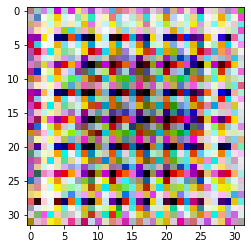

unsupervised_accuracy:1.0
supervised_accuracy:0.6403940916061401
Training GAN at Time Step 1 of Epoch 27
Training GAN at Time Step 2 of Epoch 27
Training GAN at Time Step 3 of Epoch 27
Training GAN at Time Step 4 of Epoch 27
Training GAN at Time Step 5 of Epoch 27
Training GAN at Time Step 6 of Epoch 27
Training GAN at Time Step 7 of Epoch 27
Training GAN at Time Step 8 of Epoch 27
Training GAN at Time Step 9 of Epoch 27
Training GAN at Time Step 10 of Epoch 27
Training GAN at Time Step 11 of Epoch 27
Training GAN at Time Step 12 of Epoch 27
Training GAN at Time Step 13 of Epoch 27
Training GAN at Time Step 14 of Epoch 27
Training GAN at Time Step 15 of Epoch 27
Training GAN at Time Step 16 of Epoch 27
Training GAN at Time Step 17 of Epoch 27
Training GAN at Time Step 18 of Epoch 27
Training GAN at Time Step 19 of Epoch 27
Training GAN at Time Step 20 of Epoch 27
Training GAN at Time Step 21 of Epoch 27
Training GAN at Time Step 22 of Epoch 27
Training GAN at Time Step 23 of Epoch 27
T

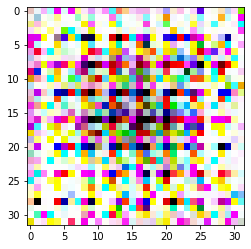

unsupervised_accuracy:1.0
supervised_accuracy:0.6380952596664429
Training GAN at Time Step 1 of Epoch 28
Training GAN at Time Step 2 of Epoch 28
Training GAN at Time Step 3 of Epoch 28
Training GAN at Time Step 4 of Epoch 28
Training GAN at Time Step 5 of Epoch 28
Training GAN at Time Step 6 of Epoch 28
Training GAN at Time Step 7 of Epoch 28
Training GAN at Time Step 8 of Epoch 28
Training GAN at Time Step 9 of Epoch 28
Training GAN at Time Step 10 of Epoch 28
Training GAN at Time Step 11 of Epoch 28
Training GAN at Time Step 12 of Epoch 28
Training GAN at Time Step 13 of Epoch 28
Training GAN at Time Step 14 of Epoch 28
Training GAN at Time Step 15 of Epoch 28
Training GAN at Time Step 16 of Epoch 28
Training GAN at Time Step 17 of Epoch 28
Training GAN at Time Step 18 of Epoch 28
Training GAN at Time Step 19 of Epoch 28
Training GAN at Time Step 20 of Epoch 28
Training GAN at Time Step 21 of Epoch 28
Training GAN at Time Step 22 of Epoch 28
Training GAN at Time Step 23 of Epoch 28
T

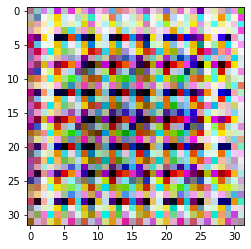

unsupervised_accuracy:1.0
supervised_accuracy:0.6405529975891113
Training GAN at Time Step 1 of Epoch 29
Training GAN at Time Step 2 of Epoch 29
Training GAN at Time Step 3 of Epoch 29
Training GAN at Time Step 4 of Epoch 29
Training GAN at Time Step 5 of Epoch 29
Training GAN at Time Step 6 of Epoch 29
Training GAN at Time Step 7 of Epoch 29
Training GAN at Time Step 8 of Epoch 29
Training GAN at Time Step 9 of Epoch 29
Training GAN at Time Step 10 of Epoch 29
Training GAN at Time Step 11 of Epoch 29
Training GAN at Time Step 12 of Epoch 29
Training GAN at Time Step 13 of Epoch 29
Training GAN at Time Step 14 of Epoch 29
Training GAN at Time Step 15 of Epoch 29
Training GAN at Time Step 16 of Epoch 29
Training GAN at Time Step 17 of Epoch 29
Training GAN at Time Step 18 of Epoch 29
Training GAN at Time Step 19 of Epoch 29
Training GAN at Time Step 20 of Epoch 29
Training GAN at Time Step 21 of Epoch 29
Training GAN at Time Step 22 of Epoch 29
Training GAN at Time Step 23 of Epoch 29
T

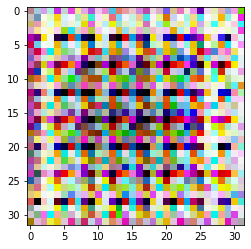

unsupervised_accuracy:1.0
supervised_accuracy:0.6473214030265808
Training GAN at Time Step 1 of Epoch 30
Training GAN at Time Step 2 of Epoch 30
Training GAN at Time Step 3 of Epoch 30
Training GAN at Time Step 4 of Epoch 30
Training GAN at Time Step 5 of Epoch 30
Training GAN at Time Step 6 of Epoch 30
Training GAN at Time Step 7 of Epoch 30
Training GAN at Time Step 8 of Epoch 30
Training GAN at Time Step 9 of Epoch 30
Training GAN at Time Step 10 of Epoch 30
Training GAN at Time Step 11 of Epoch 30
Training GAN at Time Step 12 of Epoch 30
Training GAN at Time Step 13 of Epoch 30
Training GAN at Time Step 14 of Epoch 30
Training GAN at Time Step 15 of Epoch 30
Training GAN at Time Step 16 of Epoch 30
Training GAN at Time Step 17 of Epoch 30
Training GAN at Time Step 18 of Epoch 30
Training GAN at Time Step 19 of Epoch 30
Training GAN at Time Step 20 of Epoch 30
Training GAN at Time Step 21 of Epoch 30
Training GAN at Time Step 22 of Epoch 30
Training GAN at Time Step 23 of Epoch 30
T

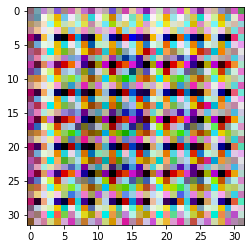

unsupervised_accuracy:1.0
supervised_accuracy:0.6536796689033508
Training GAN at Time Step 1 of Epoch 31
Training GAN at Time Step 2 of Epoch 31
Training GAN at Time Step 3 of Epoch 31
Training GAN at Time Step 4 of Epoch 31
Training GAN at Time Step 5 of Epoch 31
Training GAN at Time Step 6 of Epoch 31
Training GAN at Time Step 7 of Epoch 31
Training GAN at Time Step 8 of Epoch 31
Training GAN at Time Step 9 of Epoch 31
Training GAN at Time Step 10 of Epoch 31
Training GAN at Time Step 11 of Epoch 31
Training GAN at Time Step 12 of Epoch 31
Training GAN at Time Step 13 of Epoch 31
Training GAN at Time Step 14 of Epoch 31
Training GAN at Time Step 15 of Epoch 31
Training GAN at Time Step 16 of Epoch 31
Training GAN at Time Step 17 of Epoch 31
Training GAN at Time Step 18 of Epoch 31
Training GAN at Time Step 19 of Epoch 31
Training GAN at Time Step 20 of Epoch 31
Training GAN at Time Step 21 of Epoch 31
Training GAN at Time Step 22 of Epoch 31
Training GAN at Time Step 23 of Epoch 31
T

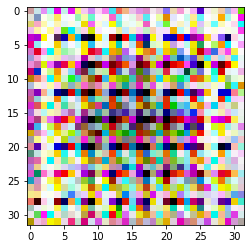

unsupervised_accuracy:1.0
supervised_accuracy:0.6554622054100037
Training GAN at Time Step 1 of Epoch 32
Training GAN at Time Step 2 of Epoch 32
Training GAN at Time Step 3 of Epoch 32
Training GAN at Time Step 4 of Epoch 32
Training GAN at Time Step 5 of Epoch 32
Training GAN at Time Step 6 of Epoch 32
Training GAN at Time Step 7 of Epoch 32
Training GAN at Time Step 8 of Epoch 32
Training GAN at Time Step 9 of Epoch 32
Training GAN at Time Step 10 of Epoch 32
Training GAN at Time Step 11 of Epoch 32
Training GAN at Time Step 12 of Epoch 32
Training GAN at Time Step 13 of Epoch 32
Training GAN at Time Step 14 of Epoch 32
Training GAN at Time Step 15 of Epoch 32
Training GAN at Time Step 16 of Epoch 32
Training GAN at Time Step 17 of Epoch 32
Training GAN at Time Step 18 of Epoch 32
Training GAN at Time Step 19 of Epoch 32
Training GAN at Time Step 20 of Epoch 32
Training GAN at Time Step 21 of Epoch 32
Training GAN at Time Step 22 of Epoch 32
Training GAN at Time Step 23 of Epoch 32
T

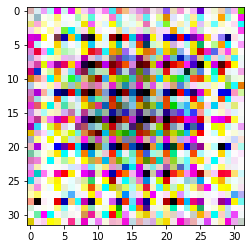

unsupervised_accuracy:1.0
supervised_accuracy:0.6571428775787354
Training GAN at Time Step 1 of Epoch 33
Training GAN at Time Step 2 of Epoch 33
Training GAN at Time Step 3 of Epoch 33
Training GAN at Time Step 4 of Epoch 33
Training GAN at Time Step 5 of Epoch 33
Training GAN at Time Step 6 of Epoch 33
Training GAN at Time Step 7 of Epoch 33
Training GAN at Time Step 8 of Epoch 33
Training GAN at Time Step 9 of Epoch 33
Training GAN at Time Step 10 of Epoch 33
Training GAN at Time Step 11 of Epoch 33
Training GAN at Time Step 12 of Epoch 33
Training GAN at Time Step 13 of Epoch 33
Training GAN at Time Step 14 of Epoch 33
Training GAN at Time Step 15 of Epoch 33
Training GAN at Time Step 16 of Epoch 33
Training GAN at Time Step 17 of Epoch 33
Training GAN at Time Step 18 of Epoch 33
Training GAN at Time Step 19 of Epoch 33
Training GAN at Time Step 20 of Epoch 33
Training GAN at Time Step 21 of Epoch 33
Training GAN at Time Step 22 of Epoch 33
Training GAN at Time Step 23 of Epoch 33
T

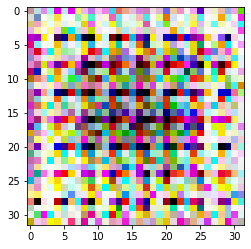

unsupervised_accuracy:1.0
supervised_accuracy:0.6507936716079712
Training GAN at Time Step 1 of Epoch 34
Training GAN at Time Step 2 of Epoch 34
Training GAN at Time Step 3 of Epoch 34
Training GAN at Time Step 4 of Epoch 34
Training GAN at Time Step 5 of Epoch 34
Training GAN at Time Step 6 of Epoch 34
Training GAN at Time Step 7 of Epoch 34
Training GAN at Time Step 8 of Epoch 34
Training GAN at Time Step 9 of Epoch 34
Training GAN at Time Step 10 of Epoch 34
Training GAN at Time Step 11 of Epoch 34
Training GAN at Time Step 12 of Epoch 34
Training GAN at Time Step 13 of Epoch 34
Training GAN at Time Step 14 of Epoch 34
Training GAN at Time Step 15 of Epoch 34
Training GAN at Time Step 16 of Epoch 34
Training GAN at Time Step 17 of Epoch 34
Training GAN at Time Step 18 of Epoch 34
Training GAN at Time Step 19 of Epoch 34
Training GAN at Time Step 20 of Epoch 34
Training GAN at Time Step 21 of Epoch 34
Training GAN at Time Step 22 of Epoch 34
Training GAN at Time Step 23 of Epoch 34
T

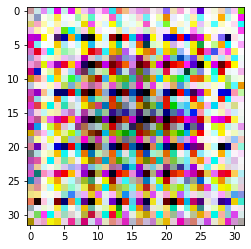

unsupervised_accuracy:1.0
supervised_accuracy:0.6525096297264099
Training GAN at Time Step 1 of Epoch 35
Training GAN at Time Step 2 of Epoch 35
Training GAN at Time Step 3 of Epoch 35
Training GAN at Time Step 4 of Epoch 35
Training GAN at Time Step 5 of Epoch 35
Training GAN at Time Step 6 of Epoch 35
Training GAN at Time Step 7 of Epoch 35
Training GAN at Time Step 8 of Epoch 35
Training GAN at Time Step 9 of Epoch 35
Training GAN at Time Step 10 of Epoch 35
Training GAN at Time Step 11 of Epoch 35
Training GAN at Time Step 12 of Epoch 35
Training GAN at Time Step 13 of Epoch 35
Training GAN at Time Step 14 of Epoch 35
Training GAN at Time Step 15 of Epoch 35
Training GAN at Time Step 16 of Epoch 35
Training GAN at Time Step 17 of Epoch 35
Training GAN at Time Step 18 of Epoch 35
Training GAN at Time Step 19 of Epoch 35
Training GAN at Time Step 20 of Epoch 35
Training GAN at Time Step 21 of Epoch 35
Training GAN at Time Step 22 of Epoch 35
Training GAN at Time Step 23 of Epoch 35
T

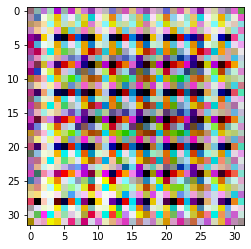

unsupervised_accuracy:1.0
supervised_accuracy:0.6578947305679321
Training GAN at Time Step 1 of Epoch 36
Training GAN at Time Step 2 of Epoch 36
Training GAN at Time Step 3 of Epoch 36
Training GAN at Time Step 4 of Epoch 36
Training GAN at Time Step 5 of Epoch 36
Training GAN at Time Step 6 of Epoch 36
Training GAN at Time Step 7 of Epoch 36
Training GAN at Time Step 8 of Epoch 36
Training GAN at Time Step 9 of Epoch 36
Training GAN at Time Step 10 of Epoch 36
Training GAN at Time Step 11 of Epoch 36
Training GAN at Time Step 12 of Epoch 36
Training GAN at Time Step 13 of Epoch 36
Training GAN at Time Step 14 of Epoch 36
Training GAN at Time Step 15 of Epoch 36
Training GAN at Time Step 16 of Epoch 36
Training GAN at Time Step 17 of Epoch 36
Training GAN at Time Step 18 of Epoch 36
Training GAN at Time Step 19 of Epoch 36
Training GAN at Time Step 20 of Epoch 36
Training GAN at Time Step 21 of Epoch 36
Training GAN at Time Step 22 of Epoch 36
Training GAN at Time Step 23 of Epoch 36
T

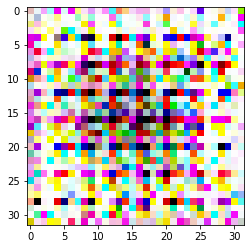

unsupervised_accuracy:1.0
supervised_accuracy:0.6593406796455383
Training GAN at Time Step 1 of Epoch 37
Training GAN at Time Step 2 of Epoch 37
Training GAN at Time Step 3 of Epoch 37
Training GAN at Time Step 4 of Epoch 37
Training GAN at Time Step 5 of Epoch 37
Training GAN at Time Step 6 of Epoch 37
Training GAN at Time Step 7 of Epoch 37
Training GAN at Time Step 8 of Epoch 37
Training GAN at Time Step 9 of Epoch 37
Training GAN at Time Step 10 of Epoch 37
Training GAN at Time Step 11 of Epoch 37
Training GAN at Time Step 12 of Epoch 37
Training GAN at Time Step 13 of Epoch 37
Training GAN at Time Step 14 of Epoch 37
Training GAN at Time Step 15 of Epoch 37
Training GAN at Time Step 16 of Epoch 37
Training GAN at Time Step 17 of Epoch 37
Training GAN at Time Step 18 of Epoch 37
Training GAN at Time Step 19 of Epoch 37
Training GAN at Time Step 20 of Epoch 37
Training GAN at Time Step 21 of Epoch 37
Training GAN at Time Step 22 of Epoch 37
Training GAN at Time Step 23 of Epoch 37
T

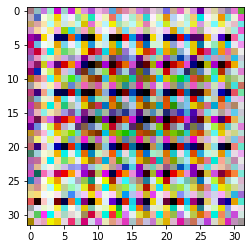

unsupervised_accuracy:1.0
supervised_accuracy:0.6535714268684387
Training GAN at Time Step 1 of Epoch 38
Training GAN at Time Step 2 of Epoch 38
Training GAN at Time Step 3 of Epoch 38
Training GAN at Time Step 4 of Epoch 38
Training GAN at Time Step 5 of Epoch 38
Training GAN at Time Step 6 of Epoch 38
Training GAN at Time Step 7 of Epoch 38
Training GAN at Time Step 8 of Epoch 38
Training GAN at Time Step 9 of Epoch 38
Training GAN at Time Step 10 of Epoch 38
Training GAN at Time Step 11 of Epoch 38
Training GAN at Time Step 12 of Epoch 38
Training GAN at Time Step 13 of Epoch 38
Training GAN at Time Step 14 of Epoch 38
Training GAN at Time Step 15 of Epoch 38
Training GAN at Time Step 16 of Epoch 38
Training GAN at Time Step 17 of Epoch 38
Training GAN at Time Step 18 of Epoch 38
Training GAN at Time Step 19 of Epoch 38
Training GAN at Time Step 20 of Epoch 38
Training GAN at Time Step 21 of Epoch 38
Training GAN at Time Step 22 of Epoch 38
Training GAN at Time Step 23 of Epoch 38
T

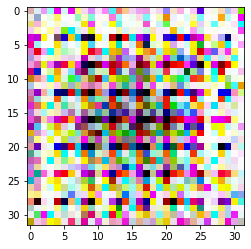

unsupervised_accuracy:1.0
supervised_accuracy:0.6585366129875183
Training GAN at Time Step 1 of Epoch 39
Training GAN at Time Step 2 of Epoch 39
Training GAN at Time Step 3 of Epoch 39
Training GAN at Time Step 4 of Epoch 39
Training GAN at Time Step 5 of Epoch 39
Training GAN at Time Step 6 of Epoch 39
Training GAN at Time Step 7 of Epoch 39
Training GAN at Time Step 8 of Epoch 39
Training GAN at Time Step 9 of Epoch 39
Training GAN at Time Step 10 of Epoch 39
Training GAN at Time Step 11 of Epoch 39
Training GAN at Time Step 12 of Epoch 39
Training GAN at Time Step 13 of Epoch 39
Training GAN at Time Step 14 of Epoch 39
Training GAN at Time Step 15 of Epoch 39
Training GAN at Time Step 16 of Epoch 39
Training GAN at Time Step 17 of Epoch 39
Training GAN at Time Step 18 of Epoch 39
Training GAN at Time Step 19 of Epoch 39
Training GAN at Time Step 20 of Epoch 39
Training GAN at Time Step 21 of Epoch 39
Training GAN at Time Step 22 of Epoch 39
Training GAN at Time Step 23 of Epoch 39
T

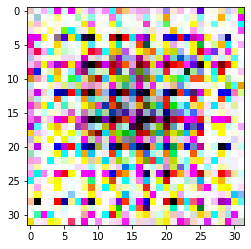

unsupervised_accuracy:1.0
supervised_accuracy:0.6632652878761292
Training GAN at Time Step 1 of Epoch 40
Training GAN at Time Step 2 of Epoch 40
Training GAN at Time Step 3 of Epoch 40
Training GAN at Time Step 4 of Epoch 40
Training GAN at Time Step 5 of Epoch 40
Training GAN at Time Step 6 of Epoch 40
Training GAN at Time Step 7 of Epoch 40
Training GAN at Time Step 8 of Epoch 40
Training GAN at Time Step 9 of Epoch 40
Training GAN at Time Step 10 of Epoch 40
Training GAN at Time Step 11 of Epoch 40
Training GAN at Time Step 12 of Epoch 40
Training GAN at Time Step 13 of Epoch 40
Training GAN at Time Step 14 of Epoch 40
Training GAN at Time Step 15 of Epoch 40
Training GAN at Time Step 16 of Epoch 40
Training GAN at Time Step 17 of Epoch 40
Training GAN at Time Step 18 of Epoch 40
Training GAN at Time Step 19 of Epoch 40
Training GAN at Time Step 20 of Epoch 40
Training GAN at Time Step 21 of Epoch 40
Training GAN at Time Step 22 of Epoch 40
Training GAN at Time Step 23 of Epoch 40
T

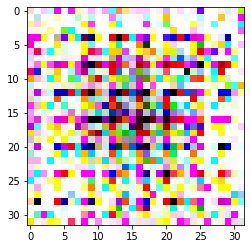

unsupervised_accuracy:1.0
supervised_accuracy:0.6644518375396729
Training GAN at Time Step 1 of Epoch 41
Training GAN at Time Step 2 of Epoch 41
Training GAN at Time Step 3 of Epoch 41
Training GAN at Time Step 4 of Epoch 41
Training GAN at Time Step 5 of Epoch 41
Training GAN at Time Step 6 of Epoch 41
Training GAN at Time Step 7 of Epoch 41
Training GAN at Time Step 8 of Epoch 41
Training GAN at Time Step 9 of Epoch 41
Training GAN at Time Step 10 of Epoch 41
Training GAN at Time Step 11 of Epoch 41
Training GAN at Time Step 12 of Epoch 41
Training GAN at Time Step 13 of Epoch 41
Training GAN at Time Step 14 of Epoch 41
Training GAN at Time Step 15 of Epoch 41
Training GAN at Time Step 16 of Epoch 41
Training GAN at Time Step 17 of Epoch 41
Training GAN at Time Step 18 of Epoch 41
Training GAN at Time Step 19 of Epoch 41
Training GAN at Time Step 20 of Epoch 41
Training GAN at Time Step 21 of Epoch 41
Training GAN at Time Step 22 of Epoch 41
Training GAN at Time Step 23 of Epoch 41
T

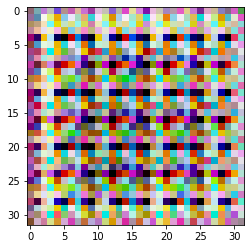

unsupervised_accuracy:1.0
supervised_accuracy:0.6655844449996948
Training GAN at Time Step 1 of Epoch 42
Training GAN at Time Step 2 of Epoch 42
Training GAN at Time Step 3 of Epoch 42
Training GAN at Time Step 4 of Epoch 42
Training GAN at Time Step 5 of Epoch 42
Training GAN at Time Step 6 of Epoch 42
Training GAN at Time Step 7 of Epoch 42
Training GAN at Time Step 8 of Epoch 42
Training GAN at Time Step 9 of Epoch 42
Training GAN at Time Step 10 of Epoch 42
Training GAN at Time Step 11 of Epoch 42
Training GAN at Time Step 12 of Epoch 42
Training GAN at Time Step 13 of Epoch 42
Training GAN at Time Step 14 of Epoch 42
Training GAN at Time Step 15 of Epoch 42
Training GAN at Time Step 16 of Epoch 42
Training GAN at Time Step 17 of Epoch 42
Training GAN at Time Step 18 of Epoch 42
Training GAN at Time Step 19 of Epoch 42
Training GAN at Time Step 20 of Epoch 42
Training GAN at Time Step 21 of Epoch 42
Training GAN at Time Step 22 of Epoch 42
Training GAN at Time Step 23 of Epoch 42
T

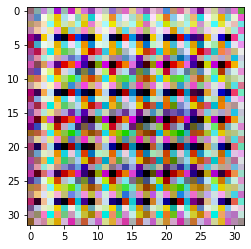

unsupervised_accuracy:1.0
supervised_accuracy:0.6698412895202637
Training GAN at Time Step 1 of Epoch 43
Training GAN at Time Step 2 of Epoch 43
Training GAN at Time Step 3 of Epoch 43
Training GAN at Time Step 4 of Epoch 43
Training GAN at Time Step 5 of Epoch 43
Training GAN at Time Step 6 of Epoch 43
Training GAN at Time Step 7 of Epoch 43
Training GAN at Time Step 8 of Epoch 43
Training GAN at Time Step 9 of Epoch 43
Training GAN at Time Step 10 of Epoch 43
Training GAN at Time Step 11 of Epoch 43
Training GAN at Time Step 12 of Epoch 43
Training GAN at Time Step 13 of Epoch 43
Training GAN at Time Step 14 of Epoch 43
Training GAN at Time Step 15 of Epoch 43
Training GAN at Time Step 16 of Epoch 43
Training GAN at Time Step 17 of Epoch 43
Training GAN at Time Step 18 of Epoch 43
Training GAN at Time Step 19 of Epoch 43
Training GAN at Time Step 20 of Epoch 43
Training GAN at Time Step 21 of Epoch 43
Training GAN at Time Step 22 of Epoch 43
Training GAN at Time Step 23 of Epoch 43
T

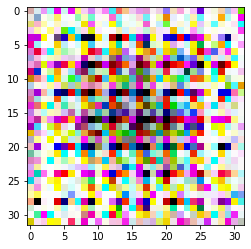

unsupervised_accuracy:1.0
supervised_accuracy:0.6708074808120728
Training GAN at Time Step 1 of Epoch 44
Training GAN at Time Step 2 of Epoch 44
Training GAN at Time Step 3 of Epoch 44
Training GAN at Time Step 4 of Epoch 44
Training GAN at Time Step 5 of Epoch 44
Training GAN at Time Step 6 of Epoch 44
Training GAN at Time Step 7 of Epoch 44
Training GAN at Time Step 8 of Epoch 44
Training GAN at Time Step 9 of Epoch 44
Training GAN at Time Step 10 of Epoch 44
Training GAN at Time Step 11 of Epoch 44
Training GAN at Time Step 12 of Epoch 44
Training GAN at Time Step 13 of Epoch 44
Training GAN at Time Step 14 of Epoch 44
Training GAN at Time Step 15 of Epoch 44
Training GAN at Time Step 16 of Epoch 44
Training GAN at Time Step 17 of Epoch 44
Training GAN at Time Step 18 of Epoch 44
Training GAN at Time Step 19 of Epoch 44
Training GAN at Time Step 20 of Epoch 44
Training GAN at Time Step 21 of Epoch 44
Training GAN at Time Step 22 of Epoch 44
Training GAN at Time Step 23 of Epoch 44
T

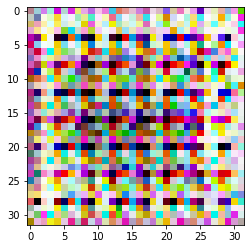

unsupervised_accuracy:1.0
supervised_accuracy:0.6686930060386658
Training GAN at Time Step 1 of Epoch 45
Training GAN at Time Step 2 of Epoch 45
Training GAN at Time Step 3 of Epoch 45
Training GAN at Time Step 4 of Epoch 45
Training GAN at Time Step 5 of Epoch 45
Training GAN at Time Step 6 of Epoch 45
Training GAN at Time Step 7 of Epoch 45
Training GAN at Time Step 8 of Epoch 45
Training GAN at Time Step 9 of Epoch 45
Training GAN at Time Step 10 of Epoch 45
Training GAN at Time Step 11 of Epoch 45
Training GAN at Time Step 12 of Epoch 45
Training GAN at Time Step 13 of Epoch 45
Training GAN at Time Step 14 of Epoch 45
Training GAN at Time Step 15 of Epoch 45
Training GAN at Time Step 16 of Epoch 45
Training GAN at Time Step 17 of Epoch 45
Training GAN at Time Step 18 of Epoch 45
Training GAN at Time Step 19 of Epoch 45
Training GAN at Time Step 20 of Epoch 45
Training GAN at Time Step 21 of Epoch 45
Training GAN at Time Step 22 of Epoch 45
Training GAN at Time Step 23 of Epoch 45
T

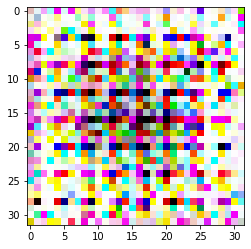

unsupervised_accuracy:1.0
supervised_accuracy:0.6696428656578064
Training GAN at Time Step 1 of Epoch 46
Training GAN at Time Step 2 of Epoch 46
Training GAN at Time Step 3 of Epoch 46
Training GAN at Time Step 4 of Epoch 46
Training GAN at Time Step 5 of Epoch 46
Training GAN at Time Step 6 of Epoch 46
Training GAN at Time Step 7 of Epoch 46
Training GAN at Time Step 8 of Epoch 46
Training GAN at Time Step 9 of Epoch 46
Training GAN at Time Step 10 of Epoch 46
Training GAN at Time Step 11 of Epoch 46
Training GAN at Time Step 12 of Epoch 46
Training GAN at Time Step 13 of Epoch 46
Training GAN at Time Step 14 of Epoch 46
Training GAN at Time Step 15 of Epoch 46
Training GAN at Time Step 16 of Epoch 46
Training GAN at Time Step 17 of Epoch 46
Training GAN at Time Step 18 of Epoch 46
Training GAN at Time Step 19 of Epoch 46
Training GAN at Time Step 20 of Epoch 46
Training GAN at Time Step 21 of Epoch 46
Training GAN at Time Step 22 of Epoch 46
Training GAN at Time Step 23 of Epoch 46
T

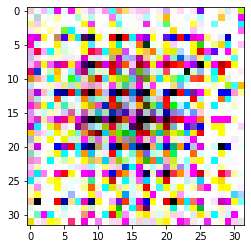

unsupervised_accuracy:1.0
supervised_accuracy:0.6676384806632996
Training GAN at Time Step 1 of Epoch 47
Training GAN at Time Step 2 of Epoch 47
Training GAN at Time Step 3 of Epoch 47
Training GAN at Time Step 4 of Epoch 47
Training GAN at Time Step 5 of Epoch 47
Training GAN at Time Step 6 of Epoch 47
Training GAN at Time Step 7 of Epoch 47
Training GAN at Time Step 8 of Epoch 47
Training GAN at Time Step 9 of Epoch 47
Training GAN at Time Step 10 of Epoch 47
Training GAN at Time Step 11 of Epoch 47
Training GAN at Time Step 12 of Epoch 47
Training GAN at Time Step 13 of Epoch 47
Training GAN at Time Step 14 of Epoch 47
Training GAN at Time Step 15 of Epoch 47
Training GAN at Time Step 16 of Epoch 47
Training GAN at Time Step 17 of Epoch 47
Training GAN at Time Step 18 of Epoch 47
Training GAN at Time Step 19 of Epoch 47
Training GAN at Time Step 20 of Epoch 47
Training GAN at Time Step 21 of Epoch 47
Training GAN at Time Step 22 of Epoch 47
Training GAN at Time Step 23 of Epoch 47
T

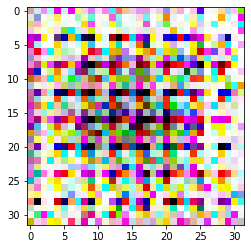

unsupervised_accuracy:1.0
supervised_accuracy:0.6628571152687073
Training GAN at Time Step 1 of Epoch 48
Training GAN at Time Step 2 of Epoch 48
Training GAN at Time Step 3 of Epoch 48
Training GAN at Time Step 4 of Epoch 48
Training GAN at Time Step 5 of Epoch 48
Training GAN at Time Step 6 of Epoch 48
Training GAN at Time Step 7 of Epoch 48
Training GAN at Time Step 8 of Epoch 48
Training GAN at Time Step 9 of Epoch 48
Training GAN at Time Step 10 of Epoch 48
Training GAN at Time Step 11 of Epoch 48
Training GAN at Time Step 12 of Epoch 48
Training GAN at Time Step 13 of Epoch 48
Training GAN at Time Step 14 of Epoch 48
Training GAN at Time Step 15 of Epoch 48
Training GAN at Time Step 16 of Epoch 48
Training GAN at Time Step 17 of Epoch 48
Training GAN at Time Step 18 of Epoch 48
Training GAN at Time Step 19 of Epoch 48
Training GAN at Time Step 20 of Epoch 48
Training GAN at Time Step 21 of Epoch 48
Training GAN at Time Step 22 of Epoch 48
Training GAN at Time Step 23 of Epoch 48
T

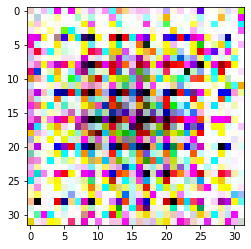

unsupervised_accuracy:1.0
supervised_accuracy:0.6554622054100037
Training GAN at Time Step 1 of Epoch 49
Training GAN at Time Step 2 of Epoch 49
Training GAN at Time Step 3 of Epoch 49
Training GAN at Time Step 4 of Epoch 49
Training GAN at Time Step 5 of Epoch 49
Training GAN at Time Step 6 of Epoch 49
Training GAN at Time Step 7 of Epoch 49
Training GAN at Time Step 8 of Epoch 49
Training GAN at Time Step 9 of Epoch 49
Training GAN at Time Step 10 of Epoch 49
Training GAN at Time Step 11 of Epoch 49
Training GAN at Time Step 12 of Epoch 49
Training GAN at Time Step 13 of Epoch 49
Training GAN at Time Step 14 of Epoch 49
Training GAN at Time Step 15 of Epoch 49
Training GAN at Time Step 16 of Epoch 49
Training GAN at Time Step 17 of Epoch 49
Training GAN at Time Step 18 of Epoch 49
Training GAN at Time Step 19 of Epoch 49
Training GAN at Time Step 20 of Epoch 49
Training GAN at Time Step 21 of Epoch 49
Training GAN at Time Step 22 of Epoch 49
Training GAN at Time Step 23 of Epoch 49
T

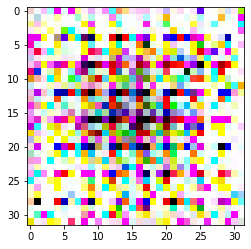

unsupervised_accuracy:1.0
supervised_accuracy:0.6483516693115234
Training GAN at Time Step 1 of Epoch 50
Training GAN at Time Step 2 of Epoch 50
Training GAN at Time Step 3 of Epoch 50
Training GAN at Time Step 4 of Epoch 50
Training GAN at Time Step 5 of Epoch 50
Training GAN at Time Step 6 of Epoch 50
Training GAN at Time Step 7 of Epoch 50
Training GAN at Time Step 8 of Epoch 50
Training GAN at Time Step 9 of Epoch 50
Training GAN at Time Step 10 of Epoch 50
Training GAN at Time Step 11 of Epoch 50
Training GAN at Time Step 12 of Epoch 50
Training GAN at Time Step 13 of Epoch 50
Training GAN at Time Step 14 of Epoch 50
Training GAN at Time Step 15 of Epoch 50
Training GAN at Time Step 16 of Epoch 50
Training GAN at Time Step 17 of Epoch 50
Training GAN at Time Step 18 of Epoch 50
Training GAN at Time Step 19 of Epoch 50
Training GAN at Time Step 20 of Epoch 50
Training GAN at Time Step 21 of Epoch 50
Training GAN at Time Step 22 of Epoch 50
Training GAN at Time Step 23 of Epoch 50
T

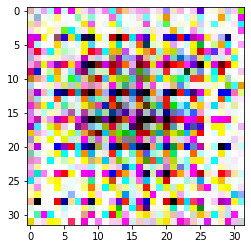

unsupervised_accuracy:1.0
supervised_accuracy:0.6495956778526306


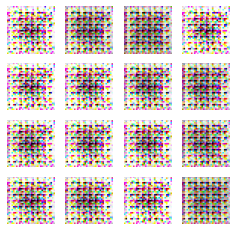

In [ ]:
train_classifier(unlabeled_img_datagen=unlabeled_datagen,labeled_img_datagen=labeled_datagen,total_epochs=GAN_epochs)